**This code computes the decomposed/monolithic solution of a Closed-Loop DRTO problem and implement in the plant.**

- The case study is a two nonlinear reactors in parallel from:*2018, Economic Coordination of Distributed Nonlinear MPC Systems using Closed-loop Prediction of a Nonlinear Dynamic Plant, H Li and C L E Swartz* 
- The underlying control structure (modeled in the CLDRTO model) contains two constrained MPC, which are represented by their KKT conditions in the DRTO problem. 
- The problem is posed as a scenario-based stochastic programming problem
- The uncertainty represented by the scenarios comes from the the heat transfer coefficient (UA) 
- We run a Monte Carlo Analysis of the performance of both strategies for an arbitrary number of scenarios

--> see jupyter notebook "Preliminaries" and "Monolithic and Decomposed CLRTO Comparison" for details

AUTHOR: Jose Matias <assumpcj@mcmaster.ca>
DATE: August 2023

[1.Model and Simulation Parameters](#sec1) <br>
[2.Building Auxiliary Functions](#sec2)<br>
[2.1. MPC matrices builder](#subsec21)<br>
[2.2. MPC solver](#subsec22)<br>
[2.3. Monolithic CLDRTO](#subsec23)<br>
[2.4. Decomposed CLDRTO](#subsec24)<br>
[2.5. Plant Model](#subsec25)<br>
[3. Implementing CL-DRTO in closed loop with the plant](#sec3)<br>

In [1]:
using LinearAlgebra, JuMP, Ipopt, CPLEX, Plots, DataFrames, LaTeXStrings, DifferentialEquations, Distributions, Random

<a id="sec1"></a>

# Model and Simulation Parameters

- Simulation Parameters

In [2]:
# Simulation sampling time
dt = 0.5 #[s]

# Plant simulation time span
tspan = (0.0,dt)

# Set seed value for choosing the plant parameter
seed = 42
Random.seed!(seed)

# Optimization horizon
ndrto = 20 # dt_DRTO

# Optimization horizon 
Δdrto = 4 # dt_DRTO

# time series for plotting
t_drto = Vector{Float64}(undef,ndrto) 
for kk in 1:ndrto
    t_drto[kk] = dt*kk
end

# number of components
nc = 3 #[-]
# number of inputs
nu = 2 #[-]
# number of reactors
nrt = 2 #[-]
# number of reactions
nrc = 2 #[-]
# number of MPCs
numpc = 2 

# initial value
C0 = [0.124287 0.216517;
    19.725 19.659;
    0.150668 0.124504]
T0 = [341.7216268417903 331.0792925101132]

# "algebraic states"
C_in0 = [20.0 10.0621;
          0 9.86252;
          0 0.0753341]
T_in0 = [299.99999999998846 320.8608134932841]
Tj_out0 = [316.6886507367161 297.43171700404525]

# "inputs"
Q0 = 0.2
Qm0 = 0.2

# initial value of u
u0 = [Q0 Qm0]

# States (algebraic and differential): CA1,CB1,CC1,T1,Tj1_out,CA2,CB2,CC2,T2,Tj2_out
x0 = [C0[1,1], C0[2,1], C0[3,1],T0[1],Tj_out0[1],C0[1,2], C0[2,2], C0[3,2],T0[2],Tj_out0[2]];

- Model Parameters

In [3]:
# feed to reactor 1 concentrations c = (A,B,C)
C1_in = [20.0, 0, 0] #[kmol/m3]

# temperature of feed to reactor 1
T1_in = 300.0 #[K]

# feed to mixer concentration c = (A,B,C)
Cm_in = [20.0, 0, 0]

# temperature of feed to mixer
Tm_in = 300.0 #[K]

# feed flowrate of cooling water to reactor jacket r = (1,2)
Qj_in = [0.7, 0.7] #[m3/s]

# cooling water temperature to reactor jacket r = (1,2)
Tj_in = [300.0, 275.0] #[m3/s]

# reactor volumetric holdup r = (1,2)
V = [5.0, 5.0] #[m3]

# heat transfer coefficient
Ua = [0.35, 0.35] #[m3/s]

# reaction rate constant e = (I,II)
k0 = [2.7e8, 160.0] #[1/s]

# reaction activation energy e = (I,II)
ER = [6000.0, 4500.0] #[K]

# heat of reaction e = (I,II)
dH_pcp = -[5.0, 5.0] #[m3 K/kmol] 

# stochiometric matrix 
Ms = [-1 0;
       1 -1;
       0 1];

In [4]:
# Uncertain parameters: Ua1 
# nominal value
pNom = 0.35
# standard deviation associated with uncertainty
deltaPar = 0.01*0.007; 

- Economic Optimization Problem Parameters

In [5]:
# feed supply limitation
Qf_max = 0.8 #[m3/s] 

# safety restriction (avoiding temperature run away) -- (350)
Tr_max = 360 #[K]

# product specifications
cA2_max = 0.3 #[kmol/m3]

# max cooling water outlet temperature r = (1,2) ([340, 310])
Tj_max = [340, 310] #[K]

# min feed to reactor 1
Q_min = 0.05 #[m3/s]

# min feed to mixer
Qm_min = 0.05; #[m3/s]

# Output bounds (T1, T2)
yMin = [100.0 100.0] #K
yMax = [350.0 350.0] #K

# Setpoint bounds (T1, T2)
yspMin = [100.0 100.0] #K
yspMax = [360.0 360.0] #K

# Input bounds (Q1, Qm)
uMin = [0.050 0.050] #K
uMax = [0.805 0.800]; #K

- Steady-state optimal solution

In [6]:
# concentration related variables
C0_star = [0.114545 0.174342;
    19.7379 19.6938;
    0.147529 0.13187]

T0_star = [350.00000000404816 337.5000000227455]
T_in0_star = [300.0 327.5923855099112]
Tj_out0_star = [320.00000000161924 300.0000000090982]
Q0_star = [0.27907949788513375 0.5057183218310063]
Qm0_star = 0.22663882394587254

solSS = Dict('C' => C0_star,
             'T' => T0_star,
             'I' => T_in0_star, 
             'J' => Tj_out0_star,
             'Q' => Q0_star,
             'M' => Qm0_star);

- MPC Parameters
MPC1: reactor 1 (Q1 <-> T1) <br>
MPC2: reactor 2 (Qm <-> T2)

In [7]:
##########
# MODELS #
##########
# reference for deviation variables
# MPC 1
T1_0_bar = 350.00000000404816
Q1_0_bar = 0.27907949788513375

# MPC 2
T2_0_bar = 337.5000000227455
Qm_0_bar = 0.22663882394587254

yref = [T1_0_bar T2_0_bar]
uref = [Q1_0_bar Qm_0_bar]

# Linear SISO model coefficients
# MPC1
a1_hat = 0.9444968979045645
b1_hat = 4.755754997301486

# MPC2
a2_hat = 0.9256356006985642
b2_hat = 5.70696857693315

# initial value of xMPC
xMPC0 = [T0[1] - T1_0_bar, T0[2] - T2_0_bar]

##########
# TUNING #
##########
# prediction horizon 
p = 5

# control horizon 
m = 3

# output tracking weight
q = 1

# move supression weight
r = [150,500]

# input bounds
u_mpc_lb = 0.050
u_mpc_ub = 0.805

##################
# KKT CONDITIONS #
##################
# matrix to compute the gradients of the input bound constraints
conMatrix = [-I(m); I(m)]

# Regularized CC function 
epsCC = [1e-2 1e-2 1e-2 1e-2 1e-2 1e-2];

- Preparing Orthogonal Collocation

In [8]:
# Parameters for orthogonal collocation
#  Radau Collocation Points 1st degree polynomial == Backward Euler
radau  = [0.0 1.00000]

# number of collocation points (initial point is also considered)
ncp = length(radau) 

# Collocation parameters and radau time series
colmat = [-1.0 -1.0;
          1.0 1.0]

# length of one finite element on the time horizon
h = dt;          

- Bender's Decomposition

In [9]:
# max number of iteration (50)
benIterMax = 75

# optimality gap (relative) tolerance 
optGap = 1e-2;

<a id="sec2"></a>

# Building auxiliary functions

<a id="subsec21"></a>

## MPC matrices builder

In [10]:
function MPC_matrices(A,B,C,p,m,q,r)
    ###########
    # inputs: #
    ###########
    # A,B,C - System model
    # p, m - prediction and control horizon
    # q, r - setpoint and input usage tuning parameters
    
    # extracting dimensions from system model
    nx = size(A,1) # states
    nu = size(B,2) # inputs
    ny = size(C,1) # outputs
    
    # adding disturbance model
    Ad = [A zeros(nx,ny); zeros(ny,nx) I(ny)]
    Bd = [B; zeros(ny,nu)]
    Cd = [C ones(ny,ny)]
    
    # building matrices for MPC
    Psi = Cd*Ad
    for ii in 2:p
        Psi = [Psi;  Cd*Ad^ii]
    end

    # Computing Dynamic Matrix
    a = Cd*Bd
    for ii in 2:p
        a = [a; Cd*Ad^(ii - 1)*Bd]
    end
    DynM = a

    for ii in 1:(m - 2)
        a = [zeros(ny,nu);a[1:(p-1)*ny,:]]
        DynM = [DynM  a]
    end

    # adjusting dynamic matrix for since p > m (last column)
    b = Cd*Bd

    Ai = I(nx+1) # adding disturbance to the states
    for ii = 1:(p - m)
        Ai = Ai + Ad^ii
        b = [b;Cd*Ai*Bd]
    end

    Theta=[DynM [zeros(ny*(m-1),nu);b]]
    
    # Creating Qbar and Rbar matrices
    Qbar = Diagonal([q for ii in 1:p])
    Rbar = Diagonal([r for ii in 1:m])

    # Creating input movement OF penalty matrix 
    M=[zeros((m-1)*nu,nu) I(nu*(m-1)); zeros(nu) zeros(nu,nu*(m-1))]
    Ibar=[I(nu); zeros(nu*(m-1),nu)]
    IM = I(nu*m) - M';
    
    # Matrix H
    H = Theta'*Qbar*Theta + IM'*Rbar*IM;
    
    return Dict('A' => A, 'B' => B, 'C' => C, 'H' => H, 'Θ' => Theta, 'Ψ' => Psi, 'Q' => Qbar, 'I' => Ibar, 'R' => Rbar, 'M' => IM)
end;

<a id="subsec23"></a>

## MPC solver

- Building function for computing MPC solution (solving QP)

In [11]:
function solveMPC(xkk,dekk,uk_1,yspk,umin,umax,yref,uref,mpc,p,m)
    ###########
    # inputs: #
    ###########
    # xkk - current states (MPC model) 
    # dekk - disturbance estimate 
    # uk_1 - inputs at the current iteration, already implemented on the plant
    # yspk - setpoint trajectory computed by CL-DRTO
    # umin, umax - input bounds
    # yref, uref - reference points for computing deviation variables
    # mpcModel - System model
    # p, m - prediction and control horizon
    
    MPC_con = Model(Ipopt.Optimizer)
    set_silent(MPC_con)
    
    ####################
    # Set up variables #
    ####################
    # inputs computed by MPCs
    @variable(MPC_con, (umin - uref) ≤ u[1:m] ≤ (umax - uref) )
    
    ######################################
    # Set up constraints and expressions #
    ######################################
    # for OF computation
    @expression(MPC_con, cfT, (mpc['Ψ']*[xkk;dekk] - (yspk - yref)*ones(p,1))'*mpc['Q']*mpc['Θ'] - (uk_1 - uref)'*mpc['I']'*mpc['R']*mpc['M'])
        
    #############################
    # Set up objective function #
    #############################
    @objective(MPC_con, Min, sum(u[jj]*sum(mpc['H'][jj,ii]*u[ii] for ii in 1:m) for jj in 1:m) + 2*sum(cfT[jj]*u[jj] for jj = 1:m))
    # @show MPC_con

    #################
    # Solve Problem #
    #################
    optimize!(MPC_con)
    
    if has_values(MPC_con)
        flag = 1
    else
        flag = 0
    end

    #calling values of the solved problem
    ϕ = objective_value(MPC_con)
    uArray = value.(u) .+ uref

    return Dict('ϕ' => ϕ,'u' => uArray, 'f' => flag)
end;

<a id="subsec23"></a>

## Monolithic solution of scenario-based CLDRTO

In [12]:
function MS_CLDRTO(C_0,T_0,u_0,xMPC_0,UaTemp,ns,solNom)
    ###########
    # inputs: #
    ###########
    # C_0, T_0 - concentration and temperature states at the current iteration (beginning of DRTO horizon)
    # u_0 - current input implemented in the plant
    # xMPC_0 - current MPC states
    # UaTemp - vector containing all the values of the uncertain parameter (Ua[1]) and Ua[2]
    # nScen - number of scenarios
    # solNom - nominal solution
    
    # Assuming equiprobable scenarios
    pScen = 1.0/ns
    
    # JuMP model
    model_ms = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model_ms, "warm_start_init_point", "yes")
    #set_optimizer_attribute(model_ms, "print_level", 5)
    set_optimizer_attribute(model_ms, "max_cpu_time", 300.0) # 5 min
    set_silent(model_ms)

    ####################
    # Set up variables #
    ####################
    # DRTO model variables
    @variable(model_ms, C[1:nc, 1:nrt, 1:ndrto, 1:ncp, 1:ns] ≥ 0)           # [kmol/m3] concentration (diff states)
    @variable(model_ms, T[rt=1:nrt, 1:ndrto, 1:ncp, 1:ns] ≥ Tj_in[rt])      # [K] reactor temperature (diff states)
    @variable(model_ms, J[1:ndrto, 1:ncp, 1:ns])                            # [$] objective function (diff states)
    @variable(model_ms, Cdot[1:nc, 1:nrt, 1:ndrto, 1:ncp, 1:ns])            # [kmol/m3/s] concentration (time derivative)
    @variable(model_ms, Tdot[1:nrt, 1:ndrto, 1:ncp, 1:ns])                  # [K/s] reactor temperature (time derivative)
    @variable(model_ms, Jdot[1:ndrto, 1:ncp, 1:ns])                         # [$/s] objective function (time derivative
    @variable(model_ms, Tj_out[rt=1:nrt, 1:ndrto, 1:ncp, 1:ns] ≥ Tj_in[rt]) # [K] reactor temperature (diff states)
    @variable(model_ms, C_in[1:nc, 1:nrt, 1:ndrto, 1:ncp, 1:ns] ≥ 0)        # [kmol/m3] inlet concentration (alg. states)
    @variable(model_ms, T_in[rt=1:nrt, 1:ndrto, 1:ncp, 1:ns] ≥ Tj_in[rt])   # [K] inlet temperature (alg. states)
    @variable(model_ms, Q_min ≤ Q[1:nrt, 1:ndrto, 1:ns] ≤ Qf_max)           # [m3/s] flowrate to reactor
    @variable(model_ms, Qm_min ≤ Qm[1:ndrto, 1:ns] ≤ Qf_max)                # [m3/s] flowrate to mixer

    # MPC model variables (SISO) -> deviation form
    @variable(model_ms, xMPC[1:numpc, 1:ndrto, 1:ns])
    #@variable(model_ms, yMPC[1:numpc, 1:ndrto, 1:ns])
    @variable(model_ms, uMPC[1:numpc, 1:ndrto, 1:m, 1:ns])
    
    # MPC <-> DRTO model deviation
    @variable(model_ms, de[1:numpc,1:ndrto, 1:ns])
    
    # Constrained MPC KKT conditions (upper and lower bounds for each input)
    @variable(model_ms, mu_g[1:numpc,1:ndrto,1:(2*m), 1:ns] ≥ 0.0) 

    # setpoints for the controllers sent to the plant (*CL-DRTO degrees of freedom)
    @variable(model_ms, yspMin[nct] ≤ ysp[nct = 1:numpc,1:ndrto, 1:ns] ≤ yspMax[nct])

    #####################################
    # Set up initial guesses for solver #
    #####################################
    if solNom isa Dict # if gives flexibility to NOT initialize variables w/ trajectories
        for ss in 1:ns
            for kk in 1:ndrto
                for jj in 1:ncp
                    for rr in 1:nrt
                        for cc in 1:nc
                            # concentration related variables
                            set_start_value(C[cc,rr,kk,jj,ss], solNom['C'][cc,rr,kk,jj,1]) 
                        end # components loop

                        # temperature related variables
                        set_start_value(T[rr,kk,jj,ss], solNom['T'][rr,kk,jj,1]) 
                        set_start_value(T_in[rr,kk,jj,ss], solNom['I'][rr,kk,jj,1])
                        set_start_value(Tj_out[rr,kk,jj,ss], solNom['J'][rr,kk,jj,1])

                    end # reactors loop
                end # collocation points loop

                # MV's
                for rr in 1:nrt
                    set_start_value(Q[rr,kk,ss], solNom['Q'][rr,kk,1])  
                end
                set_start_value(Qm[kk,ss], solNom['M'][kk,1]) 

                for mm in 1:m
                    set_start_value(uMPC[1,kk,mm,ss], solNom['u'][1,kk,mm,1])
                    set_start_value(uMPC[2,kk,mm,ss], solNom['u'][2,kk,mm,1])
                end
                
                for mm in 1:(2*m)
                    set_start_value(mu_g[1,kk,mm,ss], solNom['μ'][1,kk,mm,1])
                    set_start_value(mu_g[2,kk,mm,ss], solNom['μ'][2,kk,mm,1])
                end
            end # finite elements loop
        end # scenarios loop
    else # Set up initial guesses for solver: using opt. steady-state previoulsy computed
        for ss in 1:ns
            for kk in 1:ndrto
                for jj in 1:ncp
                    for rr in 1:nrt
                        for cc in 1:nc
                            # concentration related variables
                            set_start_value(C[cc,rr,kk,jj,ss], C0_star[cc,rr]) 
                            set_start_value(C[cc,rr,kk,jj,ss], C0_star[cc,rr]) 
                        end # components loop

                        # temperature related variables
                        set_start_value(T[rr,kk,jj,ss], T0_star[rr]) 
                        set_start_value(T_in[rr,kk,jj,ss], T_in0_star[rr])
                        set_start_value(Tj_out[rr,kk,jj,ss], Tj_out0_star[rr])

                    end # reactors loop
                end # collocation points loop

                # MV's
                for rr in 1:nrt
                    set_start_value(Q[rr,kk,ss], Q0_star[rr])  
                end
                set_start_value(Qm[kk,ss], Qm0_star) 

                for mm in 1:m
                    set_start_value(uMPC[1,kk,mm,ss], Q0_star[1] - uref[1])
                    set_start_value(uMPC[2,kk,mm,ss], Qm0_star - uref[2])
                end
            end # finite elements loop
        end # scenario loop
    end
    
    ##############
    # DRTO model #
    ##############
    @NLexpressions(model_ms, begin
            # [1/s] reaction rate
            k[rt = 1:nrt, rc = 1:nrc, kk = 1:ndrto, jj = 1:ncp, ss = 1:ns], k0[rc]*exp(-ER[rc]/T[rt,kk,jj,ss])
            #[m3 K/s] cooling rate
            # approximate model *approximating logarithm temperature
            qcool[rt = 1:nrt,kk = 1:ndrto, jj = 1:ncp, ss = 1:ns], UaTemp[rt,ss]*(T[rt,kk,jj,ss] - (0.5*(Tj_out[rt,kk,jj,ss] + Tj_in[rt])))
    end)

    @NLconstraints(model_ms, begin
            #########
            # MODEL #
            #########    
            # reactor
            r_cmb[co = 1:nc, rt = 1:nrt, kk = 1:ndrto, jj = 1:ncp, ss = 1:ns], Cdot[co,rt,kk,jj,ss] == (C_in[co,rt,kk,jj,ss] - C[co,rt,kk,jj,ss])*Q[rt,kk,ss]/V[rt] + sum(Ms[co,rc]*k[rt,rc,kk,jj,ss]*C[rc,rt,kk,jj,ss] for rc in 1:nrc) 
            r_eb[rt = 1:nrt, kk = 1:ndrto, jj = 1:ncp, ss = 1:ns], Tdot[rt,kk,jj,ss] == (T_in[rt,kk,jj,ss] - T[rt,kk,jj,ss])*Q[rt,kk,ss]/V[rt] - sum(dH_pcp[rc]*k[rt,rc,kk,jj,ss]*C[rc,rt,kk,jj,ss] for rc in 1:nrc) - qcool[rt,kk,jj,ss]/V[rt]
            # mixer
            m_mb[kk = 1:ndrto,ss = 1:ns], 0 == Q[1,kk,ss] + Qm[kk,ss] - Q[2,kk,ss]
            m_cmb[co = 1:nc,kk = 1:ndrto,jj = 1:ncp,ss = 1:ns], 0 == Q[1,kk,ss]*C[co,1,kk,jj,ss] + Qm[kk,ss]*Cm_in[co] - Q[2,kk,ss]*C_in[co,2,kk,jj,ss]
            m_eb[kk = 1:ndrto,jj = 1:ncp,ss = 1:ns], 0 == Q[1,kk,ss]*T[1,kk,jj,ss] + Qm[kk,ss]*Tm_in - Q[2,kk,ss]*T_in[2,kk,jj,ss]
            # jacket
            j_eb[rt = 1:nrt,kk = 1:ndrto,jj = 1:ncp,ss = 1:ns], 0 == Qj_in[rt]*(Tj_out[rt,kk,jj,ss] - Tj_in[rt]) - qcool[rt,kk,jj,ss]
            # objective function
            JInteg[kk = 1:ndrto, jj = 1:ncp,ss = 1:ns], Jdot[kk,jj,ss] == 10*(Q[1,kk,ss]*C_in[1,1,kk,jj,ss] + Qm[kk,ss]*Cm_in[1] - Q[2,kk,ss]*(C[1,2,kk,jj,ss] + C[3,2,kk,jj,ss])) - 0.01*qcool[1,kk,jj,ss] - qcool[2,kk,jj,ss] - 0.1*Q[1,kk,ss] - 0.1*Qm[kk,ss]

            #########################    
            # Collocation Equations #    
            #########################
            # initial point
            coll_C_0[co=1:nc, rt = 1:nrt,ss = 1:ns], C[co,rt,1,1,ss] == C_0[co,rt] 
            coll_T_0[rt = 1:nrt,ss = 1:ns], T[rt,1,1,ss] == T_0[rt]
            coll_J_0[ss = 1:ns], J[1,1,ss] == 0 
            
            # set up collocation equations 
            coll_C_n[co = 1:nc, rt = 1:nrt, kk = 1:ndrto, jj = 2:ncp,ss = 1:ns], sum(colmat[ii,jj]*C[co,rt,kk,ii,ss] for ii in 1:ncp) - h*Cdot[co,rt,kk,jj,ss] == 0 
            coll_T_n[rt = 1:nrt, kk = 1:ndrto, jj = 2:ncp, ss = 1:ns], sum(colmat[ii,jj]*T[rt,kk,ii] for ii in 1:ncp) - h*Tdot[rt,kk,jj,ss] == 0
            coll_J_n[kk = 1:ndrto, jj = 2:ncp, ss = 1:ns], sum(colmat[ii,jj]*J[kk,ii,ss] for ii in 1:ncp) - h*Jdot[kk,jj,ss] == 0

            # continuinity equations
            coll_C_con[co = 1:nc, rt = 1:nrt, kk = 2:ndrto,ss = 1:ns], C[co,rt,kk,1,ss] - C[co,rt,kk - 1,ncp,ss] == 0 
            coll_T_con[rt = 1:nrt, kk = 2:ndrto,ss = 1:ns], T[rt,kk,1,ss] - T[rt,kk - 1,ncp,ss] == 0
            coll_J_con[kk = 2:ndrto,ss = 1:ns], J[kk,1,ss] - J[kk - 1,ncp,ss] == 0
    end)
    
    ##########################
    # MPC model and solution #
    ##########################
    # N.B. inside MPC everything is in deviation variables
    @expressions(model_ms, begin
            # MPC1
            cfT_c1_1[ss = 1:ns], (mpc1['Ψ']*[xMPC[1,1,ss];de[1,1,ss]] .- (ysp[1,1,ss] - yref[1]))'*mpc1['Q']*mpc1['Θ'] - (u_0[1] - uref[1])*mpc1['I']'*mpc1['R']*mpc1['M']
            cfT_c1[kk=2:ndrto,ss = 1:ns], (mpc1['Ψ']*[xMPC[1,kk,ss];de[1,kk,ss]] .- (ysp[1,kk,ss] - yref[1]))'*mpc1['Q']*mpc1['Θ'] - uMPC[1,kk - 1,1,ss]*mpc1['I']'*mpc1['R']*mpc1['M']
            # Input bounds
            MPC1_u_upper[kk = 1:ndrto,uu = 1:m,ss = 1:ns], (uMax[1] - uref[1]) - uMPC[1,kk,uu,ss]
            MPC1_u_lower[kk = 1:ndrto,uu = 1:m,ss = 1:ns], uMPC[1,kk,uu,ss] - (uMin[1] - uref[1])
            # MPC2
            cfT_c2_1[ss = 1:ns], (mpc2['Ψ']*[xMPC[2,1,ss];de[2,1,ss]] .- (ysp[2,1,ss] - yref[2]))'*mpc2['Q']*mpc2['Θ'] - (u_0[2] - uref[2])*mpc2['I']'*mpc2['R']*mpc2['M']
            cfT_c2[kk=2:ndrto,ss = 1:ns], (mpc2['Ψ']*[xMPC[2,kk,ss];de[2,kk,ss]] .- (ysp[2,kk,ss] - yref[2]))'*mpc2['Q']*mpc2['Θ'] - uMPC[2,kk - 1,1,ss]*mpc2['I']'*mpc2['R']*mpc2['M']
            # Input bounds
            MPC2_u_upper[kk = 1:ndrto,uu = 1:m,ss = 1:ns], (uMax[2] - uref[2]) - uMPC[2,kk,uu,ss]
            MPC2_u_lower[kk = 1:ndrto,uu = 1:m,ss = 1:ns], uMPC[2,kk,uu,ss] - (uMin[2] - uref[2])
    end)

    @constraints(model_ms, begin
            #############
            # MPC model #
            #############
            # MPC1
            MPC1_dyn_model_1[ss = 1:ns], xMPC[1,1,ss] == mpc1['A']*xMPC_0[1] + mpc1['B']*(u_0[1] - uref[1])
            MPC1_dyn_model[kk = 1:(ndrto - 1),ss = 1:ns], xMPC[1,kk + 1,ss] == mpc1['A']*xMPC[1,kk,ss] + mpc1['B']*uMPC[1,kk,1,ss]
            #MPC1_model_out[kk=1:ndrto,ss = 1:ns], yMPC[1,kk,ss] == xMPC[1,kk,ss] # C = 1
            MPC1_model_dev[kk=1:ndrto,ss = 1:ns], de[1,kk,ss] == (T[1,kk,ncp,ss] - yref[1]) - xMPC[1,kk,ss]
            # MPC12
            MPC2_dyn_model_1[ss = 1:ns], xMPC[2,1,ss] == mpc2['A']*xMPC_0[2] + mpc2['B']*(u_0[2] - uref[2])
            MPC2_dyn_model[kk = 1:(ndrto - 1),ss = 1:ns], xMPC[2,kk + 1,ss] == mpc2['A']*xMPC[2,kk,ss] + mpc2['B']*uMPC[2,kk,1,ss]
            #MPC2_model_out[kk=1:ndrto,ss = 1:ns], yMPC[2,kk,ss] == xMPC[2,kk,ss] 
            MPC2_model_dev[kk=1:ndrto,ss = 1:ns], de[2,kk,ss] == (T[2,kk,ncp,ss] - yref[2]) - xMPC[2,kk,ss]
            ################
            # MPC solution #
            ################
            # MPC 1
            # stationarity
            MPC1_sol_sta_1[ss = 1:ns], uMPC[1,1,:,ss]'*mpc1['H'] + cfT_c1_1[ss] +  mu_g[1,1,:,ss]'*conMatrix .== 0
            MPC1_sol_sta[kk=2:ndrto,ss = 1:ns], uMPC[1,kk,:,ss]'*mpc1['H'] + cfT_c1[kk,ss] +  mu_g[1,kk,:,ss]'*conMatrix .== 0
            # primal feasibility
            MPC1_sol_feas_ub[kk = 1:ndrto,uu = 1:m,ss = 1:ns], MPC1_u_upper[kk,uu,ss] ≥ 0
            MPC1_sol_feas_lb[kk = 1:ndrto,uu = 1:m,ss = 1:ns], MPC1_u_lower[kk,uu,ss] ≥ 0
            # dual feasibility (already defined above)
            # complementarity constraint (defined below since it is nonlinear)
            # MPC 2
            # stationarity
            MPC2_sol_sta_1[ss = 1:ns], uMPC[2,1,:,ss]'*mpc2['H'] + cfT_c2_1[ss] +  mu_g[2,1,:,ss]'*conMatrix .== 0
            MPC2_sol_sta[kk=2:ndrto,ss = 1:ns], uMPC[2,kk,:,ss]'*mpc2['H'] + cfT_c2[kk,ss] +  mu_g[2,kk,:,ss]'*conMatrix .== 0
            # primal feasibility
            MPC2_sol_feas_ub[kk = 1:ndrto,uu = 1:m,ss = 1:ns], MPC2_u_upper[kk,uu,ss] ≥ 0
            MPC2_sol_feas_lb[kk = 1:ndrto,uu = 1:m,ss = 1:ns], MPC2_u_lower[kk,uu,ss] ≥ 0
            # dual feasibility (already defined above)
            # complementarity constraint (defined below since it is nonlinear)      
    end)
    
    @NLconstraints(model_ms, begin
            # MPC 1 
            # complementarity constraint
            MPC1_sol_cc_ub[kk = 1:ndrto,uu = 1:m,ss = 1:ns], mu_g[1,kk,uu,ss]*MPC1_u_upper[kk,uu,ss] ≤ epsCC[uu]
            MPC1_sol_cc_lb[kk = 1:ndrto,uu = 1:m,ss = 1:ns], mu_g[1,kk,m + uu,ss]*MPC1_u_lower[kk,uu,ss] ≤ epsCC[m + uu]    

            # MPC 2
            # complementarity constraint
            MPC2_sol_cc_ub[kk = 1:ndrto,uu = 1:m,ss = 1:ns], mu_g[2,kk,uu,ss]*MPC2_u_upper[kk,uu,ss] ≤ epsCC[uu]
            MPC2_sol_cc_lb[kk = 1:ndrto,uu = 1:m,ss = 1:ns], mu_g[2,kk,m + uu,ss]*MPC2_u_lower[kk,uu,ss] ≤ epsCC[m + uu] 
    end)
    
    @constraints(model_ms, begin   
            #######################
            # PROCESS CONSTRAINTS #
            #######################
            # ! Enforcing only at the end of the finite element
            # safety restrictions
            g1[rt = 1:nrt, kk = 1:ndrto,ss = 1:ns], T[rt,kk,ncp,ss] - Tr_max ≤ 0
            # product specifications (Concentration of A in reactor 2)
            g2[kk = 1:ndrto,ss = 1:ns], C[1,2,kk,ncp,ss] - cA2_max ≤ 0
            # feed supply limitations
            g3[kk = 1:ndrto,ss = 1:ns], Q[1,kk,ss] + Qm[kk,ss] - Qf_max ≤ 0
            # process limitations (others have been included when declaring variables): max cooling water outlet temperature
            g4[rt = 1:nrt, kk = 1:ndrto,ss = 1:ns], Tj_out[rt,kk,ncp,ss] - Tj_max[rt] ≤ 0    
            ############################
            # OPTIMIZATION CONSTRAINTS #
            ############################
            # connecting the MPC solution to the DRTO model (only the first element of the MV* is implemented)
            h1[kk = 1:ndrto,ss = 1:ns], (uMPC[1,kk,1,ss] + uref[1]) - Q[1,kk,ss] == 0
            h2[kk = 1:ndrto,ss = 1:ns], (uMPC[2,kk,1,ss] + uref[2]) - Qm[kk,ss] == 0
            ##################################
            # NON-ANTICIPATIVITY CONSTRAINTS #
            ##################################
            nonAnt_c1[kk=1:Δdrto,ss=2:ns], ysp[1,kk,1] - ysp[1,kk,ss] == 0.0
            nonAnt_c2[kk=1:Δdrto,ss=2:ns], ysp[2,kk,1] - ysp[2,kk,ss] == 0.0
            ##############    
            # PARAMETERS #
            ##############
            p1[co = 1:nc,kk = 1:ndrto,jj = 1:ncp,ss = 1:ns], C_in[co,1,kk,jj,ss] - C1_in[co] == 0
            p2[kk = 1:ndrto,jj = 1:ncp,ss = 1:ns], T_in[1,kk,jj,ss] - T1_in == 0
        end)
    
    # Set up objective function  
    @NLobjective(model_ms, Min, -sum(pScen*J[ndrto,ncp,ss] for ss in 1:ns))
    
    #################
    # Solve Problem #
    #################
    optimize!(model_ms)
    
    status = termination_status(model_ms)
    #display(status)
    
    if status == MOI.OPTIMAL || status == MOI.ALMOST_OPTIMAL || status == MOI.LOCALLY_SOLVED
        # Proved optimality or Optimal within relaxed tolerances
        # solution time
        timeSol = solve_time(model_ms)

        flag = 1
        # #primal_status(m)

        #calling values of the solved problem
        ϕ = objective_value(model_ms)
        yspArray = value.(ysp)
        CArray = value.(C)
        TArray = value.(T)
        TjArray = value.(Tj_out)
        TinArray = value.(T_in)
        QArray = value.(Q)
        QmArray = value.(Qm)
        
        muArray = value.(mu_g)
        uArray = value.(uMPC)

        outputFun = Dict('ϕ' => ϕ,
                        't' => timeSol,
                        'f' => flag, 
                        's' => yspArray,
                        'Q' => QArray,
                        'M' => QmArray,
                        'C' => CArray,
                        'T' => TArray, 
                        'J' => TjArray,
                        'I' => TinArray,
                        'μ' => muArray,
                        'u' => uArray)
        
        return outputFun
    else
        # Handle other cases.
        outputFun = Dict('f' => 0,
                         't' => NaN,
                         'ϕ' => NaN)
                        
        
        return outputFun
    end
end;

<a id="subsec24"></a>

## Decomposed CLDRTO

- Modeling Subproblem

In [13]:
function subp(yspFixed,C_0,T_0,u_0,xMPC_0,UaScen,pScen,solNom)    
    ###########
    # inputs: #
    ###########
    # yspFixed - setpoints determined by the master problem 
    # C_0, T_0 - concentration and temperature states at the current iteration (beginning of DRTO horizon)
    # u_0 - current input implemented in the plant
    # xMPC_0 - current MPC states
    # UaScen - vector containing the values of the uncertain parameter (Ua[1]) and Ua[2] for a given scenario
    # pScen - probability of a given scenario
    # solNom - nominal solution
    
    # JuMP model
    model_sub = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model_sub, "warm_start_init_point", "yes")
    #set_optimizer_attribute(model_sub, "print_level", 5)
    set_optimizer_attribute(model_sub, "max_cpu_time", 300.0) # 5 min
    set_silent(model_sub)

    ####################
    # Set up variables #
    ####################
    # DRTO model variables
    @variable(model_sub, C[1:nc, 1:nrt, 1:ndrto, 1:ncp] ≥ 0)           # [kmol/m3] concentration (diff states)
    @variable(model_sub, T[rt=1:nrt, 1:ndrto, 1:ncp] ≥ Tj_in[rt])      # [K] reactor temperature (diff states)
    @variable(model_sub, J[1:ndrto, 1:ncp])                            # [$] objective function (diff states)
    @variable(model_sub, Cdot[1:nc, 1:nrt, 1:ndrto, 1:ncp])            # [kmol/m3/s] concentration (time derivative)
    @variable(model_sub, Tdot[1:nrt, 1:ndrto, 1:ncp])                  # [K/s] reactor temperature (time derivative)
    @variable(model_sub, Jdot[1:ndrto, 1:ncp])                         # [$/s] objective function (time derivative
    @variable(model_sub, Tj_out[rt=1:nrt, 1:ndrto, 1:ncp] ≥ Tj_in[rt]) # [K] reactor temperature (diff states)
    @variable(model_sub, C_in[1:nc, 1:nrt, 1:ndrto, 1:ncp] ≥ 0)        # [kmol/m3] inlet concentration (alg. states)
    @variable(model_sub, T_in[rt=1:nrt, 1:ndrto, 1:ncp] ≥ Tj_in[rt])   # [K] inlet temperature (alg. states)
    @variable(model_sub, Q_min ≤ Q[1:nrt, 1:ndrto] ≤ Qf_max)           # [m3/s] flowrate to reactor
    @variable(model_sub, Qm_min ≤ Qm[1:ndrto] ≤ Qf_max)                # [m3/s] flowrate to mixer

    # MPC model variables (SISO) -> deviation form
    @variable(model_sub, xMPC[1:numpc, 1:ndrto])
    #@variable(model_sub, yMPC[1:numpc, 1:ndrto])
    @variable(model_sub, uMPC[1:numpc, 1:ndrto, 1:m])
    
    # MPC <-> DRTO model deviation
    @variable(model_sub, de[1:numpc,1:ndrto])
    
    # Constrained MPC KKT conditions (upper and lower bounds for each input)
    @variable(model_sub, mu_g[1:numpc,1:ndrto,1:(2*m)] ≥ 0.0) 

    # setpoints for the controllers sent to the plant (*CL-DRTO degrees of freedom)
    @variable(model_sub, yspMin[nct] ≤ ysp[nct = 1:numpc,1:ndrto] ≤ yspMax[nct])

    #####################################
    # Set up initial guesses for solver #
    #####################################
    if solNom isa Dict # if gives flexibility to NOT initialize variables
        for kk in 1:ndrto
            for jj in 1:ncp
                for rr in 1:nrt
                    for cc in 1:nc
                        # concentration related variables
                        set_start_value(C[cc,rr,kk,jj], solNom['C'][cc,rr,kk,jj,1]) 
                    end # components loop
                    
                    # temperature related variables
                    set_start_value(T[rr,kk,jj], solNom['T'][rr,kk,jj,1]) 
                    set_start_value(T_in[rr,kk,jj], solNom['I'][rr,kk,jj,1])
                    set_start_value(Tj_out[rr,kk,jj], solNom['J'][rr,kk,jj,1])

                end # reactors loop
            end # collocation points loop

            # MV's
            for rr in 1:nrt
                set_start_value(Q[rr,kk], solNom['Q'][rr,kk,1])  
            end
            set_start_value(Qm[kk], solNom['M'][kk,1]) 

            for mm in 1:m
                set_start_value(uMPC[1,kk,mm], solNom['u'][1,kk,mm,1])
                set_start_value(uMPC[2,kk,mm], solNom['u'][2,kk,mm,1])
            end
            
            for mm in 1:(2*m)
                set_start_value(mu_g[1,kk,mm], solNom['μ'][1,kk,mm,1])
                set_start_value(mu_g[2,kk,mm], solNom['μ'][2,kk,mm,1])
            end
            
        end # finite elements loop
    else # Set up initial guesses for solver: using opt. steady-state previoulsy computed
        for kk in 1:ndrto
            for jj in 1:ncp
                for rr in 1:nrt
                    for cc in 1:nc
                        # concentration related variables
                        set_start_value(C[cc,rr,kk,jj], C0_star[cc,rr]) 
                        set_start_value(C[cc,rr,kk,jj], C0_star[cc,rr]) 
                    end # components loop

                    # temperature related variables
                    set_start_value(T[rr,kk,jj], T0_star[rr]) 
                    set_start_value(T_in[rr,kk,jj], T_in0_star[rr])
                    set_start_value(Tj_out[rr,kk,jj], Tj_out0_star[rr])

                end # reactors loop
            end # collocation points loop

            # MV's
            for rr in 1:nrt
                set_start_value(Q[rr,kk], Q0_star[rr])  
            end
            set_start_value(Qm[kk], Qm0_star) 

            for mm in 1:m
                set_start_value(uMPC[1,kk,mm], Q0_star[1] - uref[1])
                set_start_value(uMPC[2,kk,mm], Qm0_star - uref[2])
            end
        end # finite elements loop
    end
    
    ##############
    # DRTO model #
    ##############
    @NLexpressions(model_sub, begin
            # [1/s] reaction rate
            k[rt = 1:nrt, rc = 1:nrc, kk = 1:ndrto, jj = 1:ncp], k0[rc]*exp(-ER[rc]/T[rt,kk,jj])
            #[m3 K/s] cooling rate
            # approximate model *approximating logarithm temperature
            qcool[rt = 1:nrt,kk = 1:ndrto, jj = 1:ncp], UaScen[rt]*(T[rt,kk,jj] - (0.5*(Tj_out[rt,kk,jj] + Tj_in[rt])))
    end)

    @NLconstraints(model_sub, begin
            #########
            # MODEL #
            #########    
            # reactor
            r_cmb[co = 1:nc, rt = 1:nrt, kk = 1:ndrto, jj = 1:ncp], Cdot[co,rt,kk,jj] == (C_in[co,rt,kk,jj] - C[co,rt,kk,jj])*Q[rt,kk]/V[rt] + sum(Ms[co,rc]*k[rt,rc,kk,jj]*C[rc,rt,kk,jj] for rc in 1:nrc) 
            r_eb[rt = 1:nrt, kk = 1:ndrto, jj = 1:ncp], Tdot[rt,kk,jj] == (T_in[rt,kk,jj] - T[rt,kk,jj])*Q[rt,kk]/V[rt] - sum(dH_pcp[rc]*k[rt,rc,kk,jj]*C[rc,rt,kk,jj] for rc in 1:nrc) - qcool[rt,kk,jj]/V[rt]
            # mixer
            m_mb[kk = 1:ndrto], 0 == Q[1,kk] + Qm[kk] - Q[2,kk]
            m_cmb[co = 1:nc,kk = 1:ndrto,jj = 1:ncp], 0 == Q[1,kk]*C[co,1,kk,jj] + Qm[kk]*Cm_in[co] - Q[2,kk]*C_in[co,2,kk,jj]
            m_eb[kk = 1:ndrto,jj = 1:ncp], 0 == Q[1,kk]*T[1,kk,jj] + Qm[kk]*Tm_in - Q[2,kk]*T_in[2,kk,jj]
            # jacket
            j_eb[rt = 1:nrt,kk = 1:ndrto,jj = 1:ncp], 0 == Qj_in[rt]*(Tj_out[rt,kk,jj] - Tj_in[rt]) - qcool[rt,kk,jj]
            # objective function
            JInteg[kk = 1:ndrto, jj = 1:ncp], Jdot[kk,jj] == 10*(Q[1,kk]*C_in[1,1,kk,jj] + Qm[kk]*Cm_in[1] - Q[2,kk]*(C[1,2,kk,jj] + C[3,2,kk,jj])) - 0.01*qcool[1,kk,jj] - qcool[2,kk,jj] - 0.1*Q[1,kk] - 0.1*Qm[kk]

            #########################    
            # Collocation Equations #    
            #########################
            # initial point
            coll_C_0[co=1:nc, rt = 1:nrt], C[co,rt,1,1] == C_0[co,rt] 
            coll_T_0[rt = 1:nrt], T[rt,1,1] == T_0[rt]
            coll_J_0, J[1,1] == 0 
            
            # set up collocation equations 
            coll_C_n[co = 1:nc, rt = 1:nrt, kk = 1:ndrto, jj = 2:ncp], sum(colmat[ii,jj]*C[co,rt,kk,ii] for ii in 1:ncp) - h*Cdot[co,rt,kk,jj] == 0 
            coll_T_n[rt = 1:nrt, kk = 1:ndrto, jj = 2:ncp], sum(colmat[ii,jj]*T[rt,kk,ii] for ii in 1:ncp) - h*Tdot[rt,kk,jj] == 0
            coll_J_n[kk = 1:ndrto, jj = 2:ncp], sum(colmat[ii,jj]*J[kk,ii] for ii in 1:ncp) - h*Jdot[kk,jj] == 0

            # continuinity equations
            coll_C_con[co = 1:nc, rt = 1:nrt, kk = 2:ndrto], C[co,rt,kk,1] - C[co,rt,kk - 1,ncp] == 0 
            coll_T_con[rt = 1:nrt, kk = 2:ndrto], T[rt,kk,1] - T[rt,kk - 1,ncp] == 0
            coll_J_con[kk = 2:ndrto], J[kk,1] - J[kk - 1,ncp] == 0
    end)
    
    ##########################
    # MPC model and solution #
    ##########################
    # N.B. inside MPC everything is in deviation variables
    @expressions(model_sub, begin
            # MPC1
            cfT_c1_1, (mpc1['Ψ']*[xMPC[1,1];de[1,1]] .- (ysp[1,1] - yref[1]))'*mpc1['Q']*mpc1['Θ'] - (u_0[1] - uref[1])*mpc1['I']'*mpc1['R']*mpc1['M']
            cfT_c1[kk=2:ndrto], (mpc1['Ψ']*[xMPC[1,kk];de[1,kk]] .- (ysp[1,kk] - yref[1]))'*mpc1['Q']*mpc1['Θ'] - uMPC[1,kk - 1,1]*mpc1['I']'*mpc1['R']*mpc1['M']
            # Input bounds
            MPC1_u_upper[kk = 1:ndrto,uu = 1:m], (uMax[1] - uref[1]) - uMPC[1,kk,uu]
            MPC1_u_lower[kk = 1:ndrto,uu = 1:m], uMPC[1,kk,uu] - (uMin[1] - uref[1])
            # MPC2
            cfT_c2_1, (mpc2['Ψ']*[xMPC[2,1];de[2,1]] .- (ysp[2,1] - yref[2]))'*mpc2['Q']*mpc2['Θ'] - (u_0[2] - uref[2])*mpc2['I']'*mpc2['R']*mpc2['M']
            cfT_c2[kk=2:ndrto], (mpc2['Ψ']*[xMPC[2,kk];de[2,kk]] .- (ysp[2,kk] - yref[2]))'*mpc2['Q']*mpc2['Θ'] - uMPC[2,kk - 1,1]*mpc2['I']'*mpc2['R']*mpc2['M']
            # Input bounds
            MPC2_u_upper[kk = 1:ndrto,uu = 1:m], (uMax[2] - uref[2]) - uMPC[2,kk,uu]
            MPC2_u_lower[kk = 1:ndrto,uu = 1:m], uMPC[2,kk,uu] - (uMin[2] - uref[2])
    end)

    @constraints(model_sub, begin
            #############
            # MPC model #
            #############
            # MPC1
            MPC1_dyn_model_1, xMPC[1,1] == mpc1['A']*xMPC_0[1] + mpc1['B']*(u_0[1] - uref[1])
            MPC1_dyn_model[kk = 1:(ndrto - 1)], xMPC[1,kk + 1] == mpc1['A']*xMPC[1,kk] + mpc1['B']*uMPC[1,kk,1]
            MPC1_model_dev[kk=1:ndrto], de[1,kk] == (T[1,kk,ncp] - yref[1]) - xMPC[1,kk]
            # MPC12
            MPC2_dyn_model_1, xMPC[2,1] == mpc2['A']*xMPC_0[2] + mpc2['B']*(u_0[2] - uref[2])
            MPC2_dyn_model[kk = 1:(ndrto - 1)], xMPC[2,kk + 1] == mpc2['A']*xMPC[2,kk] + mpc2['B']*uMPC[2,kk,1]
            MPC2_model_dev[kk=1:ndrto], de[2,kk] == (T[2,kk,ncp] - yref[2]) - xMPC[2,kk]
            ################
            # MPC solution #
            ################
            # MPC 1
            # stationarity
            MPC1_sol_sta_1, uMPC[1,1,:]'*mpc1['H'] + cfT_c1_1 +  mu_g[1,1,:]'*conMatrix .== 0
            MPC1_sol_sta[kk=2:ndrto], uMPC[1,kk,:]'*mpc1['H'] + cfT_c1[kk] +  mu_g[1,kk,:]'*conMatrix .== 0
            # primal feasibility
            MPC1_sol_feas_ub[kk = 1:ndrto,uu = 1:m], MPC1_u_upper[kk,uu] ≥ 0
            MPC1_sol_feas_lb[kk = 1:ndrto,uu = 1:m], MPC1_u_lower[kk,uu] ≥ 0
            # dual feasibility (already defined above)
            # complementarity constraint (defined below since it is nonlinear)
            # MPC 2
            # stationarity
            MPC2_sol_sta_1, uMPC[2,1,:]'*mpc2['H'] + cfT_c2_1 +  mu_g[2,1,:]'*conMatrix .== 0
            MPC2_sol_sta[kk=2:ndrto], uMPC[2,kk,:]'*mpc2['H'] + cfT_c2[kk] +  mu_g[2,kk,:]'*conMatrix .== 0
            # primal feasibility
            MPC2_sol_feas_ub[kk = 1:ndrto,uu = 1:m], MPC2_u_upper[kk,uu] ≥ 0
            MPC2_sol_feas_lb[kk = 1:ndrto,uu = 1:m], MPC2_u_lower[kk,uu] ≥ 0
            # dual feasibility (already defined above)
            # complementarity constraint (defined below since it is nonlinear)      
    end)
    
    @NLconstraints(model_sub, begin
            # MPC 1 
            # complementarity constraint
            MPC1_sol_cc_ub[kk = 1:ndrto,uu = 1:m], mu_g[1,kk,uu]*MPC1_u_upper[kk,uu] ≤ epsCC[uu]
            MPC1_sol_cc_lb[kk = 1:ndrto,uu = 1:m], mu_g[1,kk,m + uu]*MPC1_u_lower[kk,uu] ≤ epsCC[m + uu]    

            # MPC 2
            # complementarity constraint
            MPC2_sol_cc_ub[kk = 1:ndrto,uu = 1:m], mu_g[2,kk,uu]*MPC2_u_upper[kk,uu] ≤ epsCC[uu]
            MPC2_sol_cc_lb[kk = 1:ndrto,uu = 1:m], mu_g[2,kk,m + uu]*MPC2_u_lower[kk,uu] ≤ epsCC[m + uu] 
    end)
    
    @constraints(model_sub, begin   
            #######################
            # PROCESS CONSTRAINTS #
            #######################
            # ! Enforcing only at the end of the finite element
            # safety restrictions
            g1[rt = 1:nrt, kk = 1:ndrto], T[rt,kk,ncp] - Tr_max ≤ 0
            # product specifications (Concentration of A in reactor 2)
            g2[kk = 1:ndrto], C[1,2,kk,ncp] - cA2_max ≤ 0
            # feed supply limitations
            g3[kk = 1:ndrto], Q[1,kk] + Qm[kk] - Qf_max ≤ 0
            # process limitations (others have been included when declaring variables): max cooling water outlet temperature
            g4[rt = 1:nrt, kk = 1:ndrto], Tj_out[rt,kk,ncp] - Tj_max[rt] ≤ 0    
            ############################
            # OPTIMIZATION CONSTRAINTS #
            ############################
            # connecting the MPC solution to the DRTO model (only the first element of the MV* is implemented)
            h1[kk = 1:ndrto], (uMPC[1,kk,1] + uref[1]) - Q[1,kk] == 0
            h2[kk = 1:ndrto], (uMPC[2,kk,1] + uref[2]) - Qm[kk] == 0
            ##################################
            # NON-ANTICIPATIVITY CONSTRAINTS # <- fixed in master problem
            ##################################
            nonAnt_c1[kk=1:Δdrto], ysp[1,kk] - yspFixed[1,kk] == 0.0
            nonAnt_c2[kk=1:Δdrto], ysp[2,kk] - yspFixed[2,kk] == 0.0
            ##############    
            # PARAMETERS #
            ##############
            p1[co = 1:nc,kk = 1:ndrto,jj = 1:ncp], C_in[co,1,kk,jj] - C1_in[co] == 0
            p2[kk = 1:ndrto,jj = 1:ncp], T_in[1,kk,jj] - T1_in == 0
        end)
    
    # Set up objective function  
    @NLobjective(model_sub, Min, -pScen*J[ndrto,ncp])
    
    #################
    # Solve Problem #
    #################    
    optimize!(model_sub)
    
    # solution time
    timeSol = solve_time(model_sub)
    
    status = termination_status(model_sub)
    #display(status)
    
    # checking if there is a solution to the problem
    if status == MOI.ALMOST_LOCALLY_SOLVED || status == MOI.LOCALLY_SOLVED
        # Proved optimality or Optimal within relaxed tolerances
        # we add an optimality cut
        flag = 1
        # #primal_status(m)

        #calling values of the solved problem
        ϕ = objective_value(model_sub)
        yspArray = value.(ysp)
        CArray = value.(C)
        TArray = value.(T)
        TjArray = value.(Tj_out)
        TinArray = value.(T_in)
        QArray = value.(Q)
        QmArray = value.(Qm)

        muArray = value.(mu_g)
        
        # lagrange multipliers associated with the nonantecipativity constraints
        λ1 = dual.(nonAnt_c1)
        λ2 = dual.(nonAnt_c2)
        
        outputDict = Dict('ϕ' => ϕ,
                        't' => timeSol,
                        'f' => flag, 
                        'a' => status,
                        's' => yspArray,
                        'Q' => QArray,
                        'M' => QmArray,
                        'C' => CArray,
                        'T' => TArray, 
                        'J' => TjArray,
                        'I' => TinArray,
                        'μ' => muArray,
                        'λ' => λ1,
                        'Λ' => λ2)
        
        return outputDict
    else
        #i.e. no feasible solution --> Add feasibility cut
        #display("Feasibility cut: scenario $(scen)")        
        
        # deleting input upper bounds
        delete_upper_bound.(Q[1:nrt, 1:ndrto])
        delete_upper_bound.(Qm[1:ndrto])
        
        # keep bounds and remove process contraints
        delete.(model_sub, g1)
        delete.(model_sub, g2)
        delete.(model_sub, g3)
        delete.(model_sub, g4)

        unregister(model_sub, :g1)
        unregister(model_sub, :g2)
        unregister(model_sub, :g3)
        unregister(model_sub, :g4)
        
        # remove relaxed complementarity constraints
        delete.(model_sub, MPC1_sol_cc_ub)
        delete.(model_sub, MPC1_sol_cc_lb)
        delete.(model_sub, MPC2_sol_cc_ub)
        delete.(model_sub, MPC2_sol_cc_lb)
        
        unregister(model_sub, :MPC1_sol_cc_ub)
        unregister(model_sub, :MPC1_sol_cc_lb)
        unregister(model_sub, :MPC2_sol_cc_ub)
        unregister(model_sub, :MPC2_sol_cc_lb)
        
        ####################
        # Set up variables #
        #################### 
        # slacks
        @variable(model_sub, delta_Q[1:nrt,1:ndrto] ≥ 0.0)
        @variable(model_sub, delta_Qm[1:ndrto] ≥ 0.0)
        
        @variable(model_sub, delta_g1[1:nrt,1:ndrto] ≥ 0.0)
        @variable(model_sub, delta_g2[1:ndrto] ≥ 0.0)
        @variable(model_sub, delta_g3[1:ndrto] ≥ 0.0)
        @variable(model_sub, delta_g4[1:nrt,1:ndrto] ≥ 0.0)
        
        @variable(model_sub, delta_c1_ccub[1:ndrto,1:m] ≥ 0.0)
        @variable(model_sub, delta_c1_cclb[1:ndrto,1:m] ≥ 0.0)
        
        @variable(model_sub, delta_c2_ccub[1:ndrto,1:m] ≥ 0.0)
        @variable(model_sub, delta_c2_cclb[1:ndrto,1:m] ≥ 0.0)
        
        ###########################
        # Always-feasible problem #
        ###########################
        @constraint(model_sub, soft_Q[rt = 1:nrt, kk = 1:ndrto], Q[rt,kk] - Qf_max == delta_Q[rt,kk])
        @constraint(model_sub, soft_Qm[kk = 1:ndrto], Qm[kk] - Qf_max == delta_Qm[kk])
        
        @constraint(model_sub, soft_g1[rt = 1:nrt, kk = 1:ndrto], T[rt,kk,ncp] - Tr_max == delta_g1[rt,kk])
        @constraint(model_sub, soft_g2[kk = 1:ndrto], C[1,2,kk,ncp] - cA2_max == delta_g2[kk])
        @constraint(model_sub, soft_g3[kk = 1:ndrto], Q[1,kk] + Qm[kk] - Qf_max == delta_g3[kk])
        @constraint(model_sub, soft_g4[rt = 1:nrt, kk = 1:ndrto], Tj_out[rt,kk,ncp] - Tj_max[rt] == delta_g4[rt,kk])

        # complementarity constraint
        # MPC 1
        @constraint(model_sub, MPC1_sol_cc_ub[kk = 1:ndrto,uu = 1:m], mu_g[1,kk,uu]*MPC1_u_upper[kk,uu] == delta_c1_ccub[kk,uu])
        @constraint(model_sub, MPC1_sol_cc_lb[kk = 1:ndrto,uu = 1:m], mu_g[1,kk,m + uu]*MPC1_u_lower[kk,uu] == delta_c1_cclb[kk,uu])
        # MPC 2
        @constraint(model_sub, MPC2_sol_cc_ub[kk = 1:ndrto,uu = 1:m], mu_g[2,kk,uu]*MPC2_u_upper[kk,uu] == delta_c2_ccub[kk,uu])
        @constraint(model_sub, MPC2_sol_cc_lb[kk = 1:ndrto,uu = 1:m], mu_g[2,kk,m + uu]*MPC2_u_lower[kk,uu] == delta_c2_cclb[kk,uu])
        
       #############################
        # Set up objective function #
        #############################
        # Modifying the objective --> call @objective with the new objective function.
        # minimizing constraint violation - l1 penalty!
        @objective(model_sub, Min, 
            sum(delta_Qm[kk] + delta_g2[kk] + delta_g3[kk] + 
                sum(delta_Q[rt,kk] + delta_g1[rt,kk] + delta_g4[rt,kk] for rt in 1:nrt) + 
                sum(delta_c1_ccub[kk,uu] + delta_c1_cclb[kk,uu] + delta_c2_ccub[kk,uu] + delta_c2_cclb[kk,uu] for uu in 1:m)
                for kk in 1:ndrto)
            )
        
        #@show sub
        # re-optimizing (now using the always feasible problem)
        optimize!(model_sub)
        
        # objective function of the feasibility problem
        o = objective_value(model_sub)

        # solution time (adding time to solve the always feasible subproblem)
        timeSol = solve_time(model_sub)
        
        # checking status of the solution
        status_sub = termination_status(model_sub)
        
        # flag for calling feasibility cuts (not optimality cuts)
        flag = 0
        
        #calling values of the solved problem
        yspArray = value.(ysp)
        QArray = value.(Q)
        QmArray = value.(Qm)
        CArray = value.(C)
        TArray = value.(T)
        TinArray = value.(T_in)
        TjArray = value.(Tj_out)
        muArray = value.(mu_g)
        
        #slacks
#         dQ = value.(delta_Q)
#         dQm = value.(delta_Qm)
#         temp1 = sum(dQm[kk] + sum(dQ[rt,kk] for rt in 1:nrt) for kk in 1:ndrto)
#         display("DB: Input slacks sum: $(temp1)")
#         dg1 = value.(delta_g1)
#         dg2 = value.(delta_g2)
#         dg3 = value.(delta_g3)
#         dg4 = value.(delta_g4)
#         temp2 = sum(dg2[kk] + dg3[kk] + sum(dg1[rt,kk] + dg4[rt,kk] for rt in 1:nrt) for kk in 1:ndrto)
#         display("DB: Constraint slacks sum: $(temp2)")
        
#         dc1_ub = value.(delta_c1_ccub)
#         dc1_lb = value.(delta_c1_cclb)
#         temp3 = sum(sum(dc1_ub[kk,uu] + dc1_lb[kk,uu] for uu in 1:m) for kk in 1:ndrto)
#         display("DB: MPC1 slacks sum: $(temp3)")
        
#         dc2_ub = value.(delta_c2_ccub)
#         dc2_lb = value.(delta_c2_cclb)
#         temp4 = sum(sum(dc2_ub[kk,uu] + dc2_lb[kk,uu] for uu in 1:m) for kk in 1:ndrto)
#         display("DB: MPC2 slacks sum: $(temp4)")
        
        # lagrange multipliers associated with the nonantecipativity constraints
        λ1 = dual.(nonAnt_c1)
        λ2 = dual.(nonAnt_c2)
        
        outputDict = Dict('ϕ' => o,
                        't' => timeSol,
                        'f' => flag, 
                        'a' => status_sub,
                        's' => yspArray,
                        'Q' => QArray,
                        'M' => QmArray,
                        'C' => CArray,
                        'T' => TArray, 
                        'J' => TjArray,
                        'I' => TinArray,
                        'μ' => muArray,
                        'λ' => λ1,
                        'Λ' => λ2)
        
        return outputDict
    end
end;

- Modeling Master problem

In [14]:
## Modeling Benders Decompostion
function BENS_CLDRTO(C_0,T_0,u_0,xMPC_0,UaTemp,ns,solNom)
    ###########
    # inputs: #(xInit,uInit,nReac,nScen,pScen,solNom,option)
    ###########
    # C_0, T_0 - concentration and temperature states at the current iteration (beginning of DRTO horizon)
    # u_0 - current input implemented in the plant
    # xMPC_0 - current MPC states
    # UaTemp - vector containing all the values of the uncertain parameter (Ua[1]) and Ua[2]
    # ns - number of scenarios
    # solNom - nominal solution
    
    # Assuming equiprobable scenarios
    pScen = 1.0/ns
    
    # flag for checking if last cut was opt. (1) or feas. (0)
    flagO = 1
    
    # timing solution via Benders
    timeSolBen = 0 
    # timing solution via parallel Benders
    timeSolParBen = 0 
    
    # Define master problem model
    master = Model(Ipopt.Optimizer)
    set_silent(master)
    
    #lower bound on scenario objective function approximation 
    alpha_down = -1060; # o_nom = -1020.9613426462117
    
    # defining temp solution to avoid loop's scope
     ysp_nonⁱ = Matrix{Float64}(undef,2,Δdrto)
    
    ####################
    # Set up variables #
    ####################
    # setpoints for the controllers sent to the plant
    @variable(master, yspMin[nct] ≤ ysp[nct = 1:numpc,1:Δdrto] ≤ yspMax[nct])
    @variable(master, α ≥ alpha_down)
    
    ################################################
    # Solving problem with benders' decomposition  #
    ################################################
    for ii in 1:benIterMax
        
        ########################
        # Set up initial guess #
        ########################
        if ii == 1 # use nominal solution
            if solNom isa Dict
                for kk in 1:Δdrto
                    set_start_value(ysp[1,kk], solNom['s'][1,kk,1])
                    set_start_value(ysp[2,kk], solNom['s'][2,kk,1])
                end 
            end 
        else # use previous solution
            for kk in 1:Δdrto
                set_start_value(ysp[1,kk],  ysp_nonⁱ[1,kk])
                set_start_value(ysp[2,kk],  ysp_nonⁱ[2,kk])
            end 
        end
           
        #############################
        # Set up objective function #
        #############################
        # "nudge" next solution towards nominal solution (working = 1e-4)
        @objective(master, Min, α + 1e-2*sum(sum((ysp[nct,kk] - solNom['s'][nct,kk,1])^2 for nct = 1:numpc) for kk in 1:Δdrto))
        
        # solve master problem (with Benders' cut)
        optimize!(master)

        # solution time
        timeSolMaster = solve_time(master)
        # extracting solution for the non-anticipativity constraints
        ysp_nonⁱ = value.(ysp) 
        
        # Master problem solution: lower bound of the original problem
        lb = value(α)
        # = objective_value(master) - 0.0005*sum(sum((ysp_nonⁱ[nct,kk] - solNom['s'][nct,kk,1])^2 for nct = 1:numpc) for kk in 1:Δdrto)
        
        timeSolBen = timeSolBen + timeSolMaster
        timeSolParBen = timeSolParBen + timeSolMaster # master cannot be paralellized 

        #######################
        # Solving subproblems #
        #######################
        # objective function
        o_temp = Vector{Float64}(undef,ns)
        # flag optimality / feasibility
        flag_temp = Vector{Float64}(undef,ns)
        # solution time
        solTime_temp = Vector{Float64}(undef,ns)
        # multipliers
        lambdaN_C1_temp = Matrix{Float64}(undef,Δdrto,ns) 
        lambdaN_C2_temp = Matrix{Float64}(undef,Δdrto,ns)
        
        for ss in 1:ns
            dicTemp = subp(ysp_nonⁱ,C_0,T_0,u_0,xMPC_0,UaTemp[:,ss],pScen,solNom)

            # saving files
            # objective function
            o_temp[ss] = dicTemp['ϕ']
            # solution time
            solTime_temp[ss] = dicTemp['t']
            # optimality / feasibility flag
            flag_temp[ss] = dicTemp['f']
            # multiplier
            for kk in 1:Δdrto
                lambdaN_C1_temp[kk,ss] = dicTemp['λ'][kk]
                lambdaN_C2_temp[kk,ss] = dicTemp['Λ'][kk]
            end
            
        end
        
        ##########################################################
        # If all subproblems were feasible, check optimality gap #
        ##########################################################
        if sum(flag_temp) == ns 
            # Subproblem solution: upper bound of the original problem
            ub = sum(o_temp)

            # solve subproblems to find the upper bound of the original problem solution 
            timeSolBen = timeSolBen + sum(solTime_temp)

            # assuming that subproblem solution is parallelized
            timeSolParBen = timeSolParBen + maximum(solTime_temp)   
            
            # compute optimality gap
            gap = abs(ub - lb)/abs(ub)
#            display("DB: opt. gap $(gap)")

            # check if optimality gap is small enough
            # also, make sure last cut was an optimality cut due to change in OF 
            if gap < optGap && flagO == 1
                global yspSol_dec = ysp_nonⁱ
                global objFun_dec = ub
                global optGap_dec = gap
                global iter_dec = ii
                global time_dec = timeSolBen
                global time_max_dec = timeSolParBen
                break
            else # gap ≥ optGap 
                ##############################
                # --> adding optimality cuts #
                ##############################
                display(">>>>>> iteration $(ii):O")
                benderscutO = @constraint(master, α ≥ ub + 
                    sum(sum(lambdaN_C1_temp[jj,ss] for ss in 1:ns)*(ysp[1,jj] - ysp_nonⁱ[1,jj]) for jj in 1:Δdrto) +
                    sum(sum(lambdaN_C2_temp[jj,ss] for ss in 1:ns)*(ysp[2,jj] - ysp_nonⁱ[2,jj]) for jj in 1:Δdrto)
                )
                #@info "we are adding this bender optimality cut $(benderscutO)"
                
                # optimality cut was add
                flagO = 1
            
            end # if gap
        else # sum(flag_temp) != nScen
            ###############################
            # --> adding feasibility cuts #
            ###############################
            display(">>>>>> iteration $(ii):F")
            benderscutF = @constraint(master, 0 ≥
                sum(sum(lambdaN_C1_temp[jj,ss] for ss in 1:ns)*(ysp[1,jj] - ysp_nonⁱ[1,jj]) for jj in 1:Δdrto) +
                sum(sum(lambdaN_C2_temp[jj,ss] for ss in 1:ns)*(ysp[2,jj] - ysp_nonⁱ[2,jj]) for jj in 1:Δdrto)
                )
            #@info "we are adding this bender feasibility cut $(benderscutF)"
            
            # feasibility cut was add
            flagO = 0
            
        end # if nScen
        
        # checking if number of iterations reached max 
        if ii < benIterMax
            global yspSol_dec = [[NaN for kk=1:Δdrto] for rt=1:nrt]
            global objFun_dec = NaN
            global optGap_dec = NaN
            global iter_dec = benIterMax
            global time_dec = timeSolBen
            global time_max_dec = timeSolParBen
        end # if < benIterMax
    end # if for benders iterations

    #####################
    # Extracting values #
    #####################
    if isnan(objFun_dec)
        
        outputFun = Dict('t' => timeSolBen,
                         'ϕ' => objFun_dec,
                         'τ' => time_max_dec, 
                         'i' => iter_dec,
                         'd' => yspSol_dec,
                         'g' => optGap_dec,
                         'f' => 0)
                        
        
        return outputFun
        
    else
        QArray = Array{Float64}(undef,nrt,ndrto,ns)
        QmArray = Matrix{Float64}(undef,ndrto,ns)
        TArray = Array{Float64}(undef,nrt,ndrto,ncp,ns)
        TjArray = Array{Float64}(undef,nrt,ndrto,ncp,ns)
        yspArray = Array{Float64}(undef,numpc,ndrto,ns)

        for ss in 1:ns
            dicTemp = subp(yspSol_dec,C_0,T_0,u_0,xMPC_0,UaTemp[:,ss],pScen,solNom)

            # saving files
            QArray[:,:,ss] = dicTemp['Q']
            QmArray[:,ss] = dicTemp['M']
            TArray[:,:,:,ss] = dicTemp['T']
            TjArray[:,:,:,ss] = dicTemp['J']
            yspArray[:,:,ss] = dicTemp['s']
        end

        #calling values of the solved problem    
        outputFun =  Dict('ϕ' => objFun_dec,
                    't' => time_dec,
                    'τ' => time_max_dec, 
                    'i' => iter_dec,
                    'd' => yspSol_dec,
                    'g' => optGap_dec,
                    'Q' => QArray,
                    'M' => QmArray,
                    'T' => TArray, 
                    'J' => TjArray,
                    's' => yspArray,
                    'f' => 1)  
        
        return outputFun

    end
end;

<a id="subsec25"></a>

## Plant Model

In [15]:
function twoCSTRS_dae!(dx, x, p, t)
    CA1,CB1,CC1,T1,Tj1_out,CA2,CB2,CC2,T2,Tj2_out = x
    Q1,Qm,UaPlant = p
    
    # reactor 1
    dx[1] = (C1_in[1] - CA1)*Q1/V[1] - k0[1]*exp(-ER[1]/T1)*CA1 
    dx[2] = (C1_in[2] - CB1)*Q1/V[1] + k0[1]*exp(-ER[1]/T1)*CA1 - k0[2]*exp(-ER[2]/T1)*CB1
    dx[3] = (C1_in[3] - CC1)*Q1/V[1] + k0[2]*exp(-ER[2]/T1)*CB1
    dx[4] = (T1_in - T1)*Q1/V[1] - dH_pcp[1]*k0[1]*exp(-ER[1]/T1)*CA1 - dH_pcp[2]*k0[2]*exp(-ER[2]/T1)*CB1 - UaPlant*(T1 - (0.5*(Tj1_out + Tj_in[1])))/V[1]
    dx[5] = Qj_in[1]*(Tj1_out - Tj_in[1]) - UaPlant*(T1 - (0.5*(Tj1_out + Tj_in[1])))
    # reactor 2
    dx[6] = ((Q1*CA1 + Qm*Cm_in[1])/(Q1 + Qm) - CA2)*(Q1 + Qm)/V[2] - k0[1]*exp(-ER[1]/T2)*CA2 
    dx[7] = ((Q1*CB1 + Qm*Cm_in[2])/(Q1 + Qm) - CB2)*(Q1 + Qm)/V[2] + k0[1]*exp(-ER[1]/T2)*CA2 - k0[2]*exp(-ER[2]/T2)*CB2 
    dx[8] = ((Q1*CC1 + Qm*Cm_in[3])/(Q1 + Qm) - CC2)*(Q1 + Qm)/V[2] + k0[2]*exp(-ER[2]/T2)*CB2 
    dx[9] = ((Q1*T1 + Qm*Tm_in)/(Q1 + Qm) - T2)*(Q1 + Qm)/V[2] - dH_pcp[1]*k0[1]*exp(-ER[1]/T2)*CA2 - dH_pcp[2]*k0[2]*exp(-ER[2]/T2)*CB2 - Ua[2]*(T2 - (0.5*(Tj2_out + Tj_in[2])))/V[2]
    dx[10] = Qj_in[2]*(Tj2_out - Tj_in[2]) - Ua[2]*(T2 - (0.5*(Tj2_out + Tj_in[2])))
    
    nothing
end

# mass matrix to determine algebraic equations
M = [1. 0 0 0 0 0 0 0 0 0;
     0 1. 0 0 0 0 0 0 0 0;
     0 0 1. 0 0 0 0 0 0 0;
     0 0 0 1. 0 0 0 0 0 0;
     0 0 0 0 0 0 0 0 0 0;
     0 0 0 0 0 1. 0 0 0 0;
     0 0 0 0 0 0 1. 0 0 0;
     0 0 0 0 0 0 0 1. 0 0;
     0 0 0 0 0 0 0 0 1. 0;
     0 0 0 0 0 0 0 0 0 0]

ode_fun_mm = ODEFunction(twoCSTRS_dae!,mass_matrix=M);

<a id="sec3"></a>

# Implementing CL-DRTO in closed loop with the plant

Here we run a Monte Carlo Analysis of the CL-DRTO results. The uncertain parameter value is drawn at each MC iteration and the DRTO has access to the lower and upper bound of that distribution to create the scenarios. 

Getting the solution for the nominal scenario

In [16]:
# building MPC's
# reactor 1 MPC: T1 <-> Q1
mpc1 = MPC_matrices(a1_hat,b1_hat,1,p,m,q,r[1])
# reactor 2 MPC: T2 <-> Qm
mpc2 = MPC_matrices(a2_hat,b2_hat,1,p,m,q,r[2]);

In [17]:
# Monte Carlo iterations
n_MC = 2

# Simulation time in sampling periods
nsim = 40

# number of scenarios
nS_MC = 3 

# creating uncertain parameter array
pTemp = LinRange(pNom - deltaPar,pNom + deltaPar, nS_MC)
pUnc = [pTemp'; Ua[2]*ones(1,nS_MC)]

#equiprobable scenarios
pS_MC = 1.0/nS_MC

# Extracting solution for plotting --> monolithic vs. decomposed 
TrPlant = Array{Float64}(undef,nrt,nsim,n_MC,2)
TjPlant = Array{Float64}(undef,nrt,nsim,n_MC,2)
QPlant = Array{Float64}(undef,nsim,n_MC,2)
QmPlant = Array{Float64}(undef,nsim,n_MC,2)
yspPlant = Array{Float64}(undef,nrt,nsim,n_MC,2)
flagCLDRTO = Array{Float64}(undef,nsim,n_MC,2);

## Plant simulation

In [18]:
for jj = 1:n_MC
    # ramdonly drawing the plant from the previously computed models
    d = Truncated(Normal(pNom, deltaPar), pNom - 3*deltaPar, pNom + 3*deltaPar)  #Construct the distribution type
    pPlant = rand(d)
    
    # RUNNING SIMULATION
    for mm = 1:2
        
        # preparing simulation (starting from opt steady-state)
        # plant 
        xk = x0
        uk_1 = [Q0[1] Qm0]

        # mpc's models - initial states is the same
        xk_mpc1 = x0[4] - T1_0_bar
        dek_mpc1 = 0.0
        xk_mpc2 = x0[9] - T2_0_bar
        dek_mpc2 = 0.0
        
        # initial conditions (CLDRTO)
        Cpk = C0
        Tpk = T0
        
        solNom = MS_CLDRTO(Cpk,Tpk,uk_1,[xk_mpc1;xk_mpc2],Ua,1,0)
        
        for ii = 1:nsim

            print("MC: ", jj)
            println(">> Time: ",ii)

            # updating arrays # States (algebraic and differential): CA1,CB1,CC1,T1,Tj1_out,CA2,CB2,CC2,T2,Tj2_out
            TrPlant[1,ii,jj,mm] = xk[4]
            TrPlant[2,ii,jj,mm] = xk[9]
            TjPlant[1,ii,jj,mm] = xk[5]
            TjPlant[2,ii,jj,mm] = xk[10]
            QPlant[ii,jj,mm] = uk_1[1]
            QmPlant[ii,jj,mm] = uk_1[2]

            # executing DRTO
            if ii%Δdrto == 0 || ii == 1
                
                if ii > 1
                    sol_1s_temp = MS_CLDRTO(Cpk,Tpk,uk_1,[xk_mpc1;xk_mpc2],Ua,1,solNom)
                    # checking if 1s solution converged
                    if sol_1s_temp['f'] == 1
                        display("Nominal solution found")
                        solNom = sol_1s_temp 
                    else
                        # using SS as guess
                        sol_1s_temp = MS_CLDRTO(Cpk,Tpk,uk_1,[xk_mpc1;xk_mpc2],Ua,1,0)
                        if sol_1s_temp['f'] == 1
                            display("Nominal solution found (SS)")
                            solNom = sol_1s_temp  
                        else
                            display("Nominal solution not found")
                        end
                    end
                end
                
                
                if mm == 1
                    sol_temp = MS_CLDRTO(Cpk,Tpk,uk_1,[xk_mpc1;xk_mpc2],pUnc,nS_MC,solNom)
                else
                    sol_temp = BENS_CLDRTO(Cpk,Tpk,uk_1,[xk_mpc1;xk_mpc2],pUnc,nS_MC,solNom)
                end
                
                # checking solution
                if sol_temp['f'] == 1
                    display("Solution found")
                    # updating the solution
                    global sol_k = sol_temp
                    # counter for DRTO executions
                    global countDRTO = 1;
                    # N.B. need to declare as global due to loop scope
                else
                    display("Solution not found")
                    # does not update either the solution or the counter 
                end
            end
            
            # saving flag: surrogate for CLDRTO flag
            flagCLDRTO[ii,jj,mm] = countDRTO

            # Preparing controller 
            yspk = sol_k['s'][:,countDRTO,2] 
            countDRTO += 1 
            # N.B.:
            # using nominal (center) scenario, but any scenario could be used

            # solving MPC
            sol1 = solveMPC(xk_mpc1,dek_mpc1,uk_1[1],yspk[1],u_mpc_lb,u_mpc_ub,T1_0_bar,Q1_0_bar,mpc1,p,q)
            sol2 = solveMPC(xk_mpc2,dek_mpc2,uk_1[2],yspk[2],u_mpc_lb,u_mpc_ub,T2_0_bar,Qm_0_bar,mpc2,p,q)
            
            # evolving plant
            ode_prob_mm = ODEProblem(ode_fun_mm,xk,tspan,[sol1['u'][1],sol2['u'][1],pPlant]);
            sol =  solve(ode_prob_mm, Rodas5(),reltol=1e-8,abstol=1e-8,save_everystep = false);

            # loop
            # -> Plant 
            xk = sol.u[end]
            uk_1 = [sol1['u'][1],sol2['u'][1]]
            
            # -> MPCs
            # evolving MPC models
            xk_mpc1  = a1_hat*xk_mpc1 + b1_hat*(sol1['u'][1] - Q1_0_bar)
            dek_mpc1 = sol.u[end][4] - (xk_mpc1 + T1_0_bar)

            xk_mpc2  = a2_hat*xk_mpc2 + b2_hat*(sol2['u'][1] - Qm_0_bar)
            dek_mpc2 = sol.u[end][9] - (xk_mpc2 + T2_0_bar)

            # -> DRTO
            Cpk = [xk[1] xk[6];
                   xk[2] xk[7];
                   xk[3] xk[8]]
            Tpk = [xk[4] xk[9]]
            
            # saving CLDRTO decisions
            yspPlant[1,ii,jj,mm] = yspk[1]
            yspPlant[2,ii,jj,mm] = yspk[2]
            
            
            
        end # simulation
    end # monolithic || decomposed
end # MC


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

MC: 1>> Time: 1


"Solution found"

MC: 1>> Time: 2
MC: 1>> Time: 3
MC: 1>> Time: 4


"Nominal solution found"

"Solution found"

MC: 1>> Time: 5
MC: 1>> Time: 6
MC: 1>> Time: 7
MC: 1>> Time: 8


"Nominal solution found"

"Solution found"

MC: 1>> Time: 9
MC: 1>> Time: 10
MC: 1>> Time: 11
MC: 1>> Time: 12


"Nominal solution found"

"Solution found"

MC: 1>> Time: 13
MC: 1>> Time: 14
MC: 1>> Time: 15
MC: 1>> Time: 16


"Nominal solution found"

"Solution found"

MC: 1>> Time: 17
MC: 1>> Time: 18
MC: 1>> Time: 19
MC: 1>> Time: 20


"Nominal solution found"

"Solution found"

MC: 1>> Time: 21
MC: 1>> Time: 22
MC: 1>> Time: 23
MC: 1>> Time: 24


"Nominal solution found"

"Solution found"

MC: 1>> Time: 25
MC: 1>> Time: 26
MC: 1>> Time: 27
MC: 1>> Time: 28


"Nominal solution found"

"Solution found"

MC: 1>> Time: 29
MC: 1>> Time: 30
MC: 1>> Time: 31
MC: 1>> Time: 32


"Nominal solution found"

"Solution found"

MC: 1>> Time: 33
MC: 1>> Time: 34
MC: 1>> Time: 35
MC: 1>> Time: 36


"Nominal solution found"

"Solution found"

MC: 1>> Time: 37
MC: 1>> Time: 38
MC: 1>> Time: 39
MC: 1>> Time: 40


"Nominal solution found"

"Solution found"

MC: 1>> Time: 1


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

">>>>>> iteration 22:O"

">>>>>> iteration 23:O"

">>>>>> iteration 24:O"

">>>>>> iteration 25:O"

">>>>>> iteration 26:O"

">>>>>> iteration 27:O"

">>>>>> iteration 28:O"

">>>>>> iteration 29:O"

">>>>>> iteration 30:O"

">>>>>> iteration 31:O"

">>>>>> iteration 32:O"

">>>>>> iteration 33:O"

">>>>>> iteration 34:O"

">>>>>> iteration 35:O"

">>>>>> iteration 36:O"

">>>>>> iteration 37:O"

">>>>>> iteration 38:O"

">>>>>> iteration 39:O"

">>>>>> iteration 40:O"

">>>>>> iteration 41:O"

">>>>>> iteration 42:O"

">>>>>> iteration 43:O"

">>>>>> iteration 44:O"

">>>>>> iteration 45:O"

">>>>>> iteration 46:O"

">>>>>> iteration 47:O"

">>>>>> iteration 48:O"

">>>>>> iteration 49:O"

">>>>>> iteration 50:O"

">>>>>> iteration 51:O"

">>>>>> iteration 52:O"

">>>>>> iteration 53:O"

">>>>>> iteration 54:O"

">>>>>> iteration 55:O"

">>>>>> iteration 56:O"

">>>>>> iteration 57:O"

">>>>>> iteration 58:O"

">>>>>> iteration 59:O"

">>>>>> iteration 60:O"

">>>>>> iteration 61:O"

">>>>>> iteration 62:O"

">>>>>> iteration 63:O"

">>>>>> iteration 64:O"

">>>>>> iteration 65:O"

">>>>>> iteration 66:O"

">>>>>> iteration 67:O"

">>>>>> iteration 68:O"

">>>>>> iteration 69:O"

">>>>>> iteration 70:O"

">>>>>> iteration 71:O"

">>>>>> iteration 72:O"

">>>>>> iteration 73:O"

">>>>>> iteration 74:O"

">>>>>> iteration 75:O"

"Solution not found"

MC: 1>> Time: 2
MC: 1>> Time: 3
MC: 1>> Time: 4


"Nominal solution not found"

">>>>>> iteration 1:F"

">>>>>> iteration 2:F"

">>>>>> iteration 3:F"

">>>>>> iteration 4:F"

">>>>>> iteration 5:F"

">>>>>> iteration 6:F"

">>>>>> iteration 7:F"

">>>>>> iteration 8:F"

">>>>>> iteration 9:F"

">>>>>> iteration 10:F"

">>>>>> iteration 11:F"

">>>>>> iteration 12:F"

">>>>>> iteration 13:F"

">>>>>> iteration 14:F"

">>>>>> iteration 15:F"

">>>>>> iteration 16:F"

">>>>>> iteration 17:F"

">>>>>> iteration 18:F"

">>>>>> iteration 19:F"

">>>>>> iteration 20:F"

">>>>>> iteration 21:F"

">>>>>> iteration 22:F"

">>>>>> iteration 23:F"

">>>>>> iteration 24:F"

">>>>>> iteration 25:F"

">>>>>> iteration 26:F"

">>>>>> iteration 27:F"

">>>>>> iteration 28:F"

">>>>>> iteration 29:F"

">>>>>> iteration 30:F"

">>>>>> iteration 31:F"

">>>>>> iteration 32:F"

">>>>>> iteration 33:F"

">>>>>> iteration 34:F"

">>>>>> iteration 35:F"

">>>>>> iteration 36:F"

">>>>>> iteration 37:F"

">>>>>> iteration 38:F"

">>>>>> iteration 39:F"

">>>>>> iteration 40:F"

">>>>>> iteration 41:F"

">>>>>> iteration 42:F"

">>>>>> iteration 43:F"

">>>>>> iteration 44:F"

">>>>>> iteration 45:F"

">>>>>> iteration 46:F"

">>>>>> iteration 47:F"

">>>>>> iteration 48:F"

">>>>>> iteration 49:F"

">>>>>> iteration 50:F"

">>>>>> iteration 51:F"

">>>>>> iteration 52:F"

">>>>>> iteration 53:F"

">>>>>> iteration 54:F"

">>>>>> iteration 55:F"

">>>>>> iteration 56:F"

">>>>>> iteration 57:F"

">>>>>> iteration 58:F"

">>>>>> iteration 59:F"

">>>>>> iteration 60:F"

">>>>>> iteration 61:F"

">>>>>> iteration 62:F"

">>>>>> iteration 63:F"

">>>>>> iteration 64:F"

">>>>>> iteration 65:F"

">>>>>> iteration 66:F"

">>>>>> iteration 67:F"

">>>>>> iteration 68:F"

">>>>>> iteration 69:F"

">>>>>> iteration 70:F"

">>>>>> iteration 71:F"

">>>>>> iteration 72:F"

">>>>>> iteration 73:F"

">>>>>> iteration 74:F"

">>>>>> iteration 75:F"

"Solution not found"

MC: 1>> Time: 5
MC: 1>> Time: 6
MC: 1>> Time: 7
MC: 1>> Time: 8


"Nominal solution found"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

">>>>>> iteration 22:O"

">>>>>> iteration 23:O"

">>>>>> iteration 24:O"

">>>>>> iteration 25:O"

">>>>>> iteration 26:O"

">>>>>> iteration 27:O"

">>>>>> iteration 28:O"

">>>>>> iteration 29:O"

">>>>>> iteration 30:O"

">>>>>> iteration 31:O"

">>>>>> iteration 32:O"

">>>>>> iteration 33:O"

">>>>>> iteration 34:O"

">>>>>> iteration 35:O"

">>>>>> iteration 36:O"

">>>>>> iteration 37:O"

">>>>>> iteration 38:O"

">>>>>> iteration 39:O"

">>>>>> iteration 40:O"

">>>>>> iteration 41:O"

">>>>>> iteration 42:O"

">>>>>> iteration 43:O"

">>>>>> iteration 44:O"

">>>>>> iteration 45:O"

">>>>>> iteration 46:O"

">>>>>> iteration 47:O"

">>>>>> iteration 48:O"

">>>>>> iteration 49:O"

">>>>>> iteration 50:O"

">>>>>> iteration 51:O"

">>>>>> iteration 52:O"

">>>>>> iteration 53:O"

">>>>>> iteration 54:O"

">>>>>> iteration 55:O"

">>>>>> iteration 56:O"

">>>>>> iteration 57:O"

">>>>>> iteration 58:O"

">>>>>> iteration 59:O"

">>>>>> iteration 60:O"

">>>>>> iteration 61:O"

">>>>>> iteration 62:O"

">>>>>> iteration 63:O"

">>>>>> iteration 64:O"

">>>>>> iteration 65:O"

">>>>>> iteration 66:O"

">>>>>> iteration 67:O"

">>>>>> iteration 68:O"

">>>>>> iteration 69:O"

">>>>>> iteration 70:O"

">>>>>> iteration 71:O"

">>>>>> iteration 72:O"

">>>>>> iteration 73:O"

">>>>>> iteration 74:O"

">>>>>> iteration 75:O"

"Solution not found"

MC: 1>> Time: 9
MC: 1>> Time: 10
MC: 1>> Time: 11
MC: 1>> Time: 12


"Nominal solution found"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

">>>>>> iteration 22:O"

">>>>>> iteration 23:O"

">>>>>> iteration 24:O"

">>>>>> iteration 25:O"

">>>>>> iteration 26:O"

">>>>>> iteration 27:O"

">>>>>> iteration 28:O"

">>>>>> iteration 29:O"

">>>>>> iteration 30:O"

">>>>>> iteration 31:O"

">>>>>> iteration 32:O"

">>>>>> iteration 33:O"

">>>>>> iteration 34:O"

">>>>>> iteration 35:O"

">>>>>> iteration 36:O"

">>>>>> iteration 37:O"

">>>>>> iteration 38:O"

">>>>>> iteration 39:O"

">>>>>> iteration 40:O"

">>>>>> iteration 41:O"

">>>>>> iteration 42:O"

">>>>>> iteration 43:O"

">>>>>> iteration 44:O"

">>>>>> iteration 45:O"

">>>>>> iteration 46:O"

">>>>>> iteration 47:O"

">>>>>> iteration 48:O"

">>>>>> iteration 49:O"

">>>>>> iteration 50:O"

">>>>>> iteration 51:O"

">>>>>> iteration 52:O"

">>>>>> iteration 53:O"

">>>>>> iteration 54:O"

">>>>>> iteration 55:O"

">>>>>> iteration 56:O"

">>>>>> iteration 57:O"

">>>>>> iteration 58:O"

">>>>>> iteration 59:O"

">>>>>> iteration 60:O"

">>>>>> iteration 61:O"

">>>>>> iteration 62:O"

">>>>>> iteration 63:O"

">>>>>> iteration 64:O"

">>>>>> iteration 65:O"

">>>>>> iteration 66:O"

">>>>>> iteration 67:O"

">>>>>> iteration 68:O"

">>>>>> iteration 69:O"

">>>>>> iteration 70:O"

">>>>>> iteration 71:O"

">>>>>> iteration 72:O"

">>>>>> iteration 73:O"

">>>>>> iteration 74:O"

">>>>>> iteration 75:O"

"Solution not found"

MC: 1>> Time: 13
MC: 1>> Time: 14
MC: 1>> Time: 15
MC: 1>> Time: 16


"Nominal solution found"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

">>>>>> iteration 22:O"

">>>>>> iteration 23:O"

">>>>>> iteration 24:O"

">>>>>> iteration 25:O"

">>>>>> iteration 26:O"

">>>>>> iteration 27:O"

">>>>>> iteration 28:O"

">>>>>> iteration 29:O"

">>>>>> iteration 30:O"

">>>>>> iteration 31:O"

">>>>>> iteration 32:O"

">>>>>> iteration 33:O"

">>>>>> iteration 34:O"

">>>>>> iteration 35:O"

">>>>>> iteration 36:O"

">>>>>> iteration 37:O"

">>>>>> iteration 38:O"

">>>>>> iteration 39:O"

">>>>>> iteration 40:O"

">>>>>> iteration 41:O"

">>>>>> iteration 42:O"

">>>>>> iteration 43:O"

">>>>>> iteration 44:O"

">>>>>> iteration 45:O"

">>>>>> iteration 46:O"

">>>>>> iteration 47:O"

">>>>>> iteration 48:O"

">>>>>> iteration 49:O"

">>>>>> iteration 50:O"

">>>>>> iteration 51:O"

">>>>>> iteration 52:O"

">>>>>> iteration 53:O"

">>>>>> iteration 54:O"

">>>>>> iteration 55:O"

">>>>>> iteration 56:O"

">>>>>> iteration 57:O"

">>>>>> iteration 58:O"

">>>>>> iteration 59:O"

">>>>>> iteration 60:O"

">>>>>> iteration 61:O"

">>>>>> iteration 62:O"

">>>>>> iteration 63:O"

">>>>>> iteration 64:O"

">>>>>> iteration 65:O"

">>>>>> iteration 66:O"

">>>>>> iteration 67:O"

">>>>>> iteration 68:O"

">>>>>> iteration 69:O"

">>>>>> iteration 70:O"

">>>>>> iteration 71:O"

">>>>>> iteration 72:O"

">>>>>> iteration 73:O"

">>>>>> iteration 74:O"

">>>>>> iteration 75:O"

"Solution not found"

MC: 1>> Time: 17
MC: 1>> Time: 18
MC: 1>> Time: 19
MC: 1>> Time: 20


"Nominal solution found"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

">>>>>> iteration 22:O"

">>>>>> iteration 23:O"

">>>>>> iteration 24:O"

">>>>>> iteration 25:O"

">>>>>> iteration 26:O"

">>>>>> iteration 27:O"

">>>>>> iteration 28:O"

">>>>>> iteration 29:O"

">>>>>> iteration 30:O"

">>>>>> iteration 31:O"

">>>>>> iteration 32:O"

">>>>>> iteration 33:O"

">>>>>> iteration 34:O"

">>>>>> iteration 35:O"

">>>>>> iteration 36:O"

">>>>>> iteration 37:O"

">>>>>> iteration 38:O"

">>>>>> iteration 39:O"

">>>>>> iteration 40:O"

">>>>>> iteration 41:O"

">>>>>> iteration 42:O"

">>>>>> iteration 43:O"

">>>>>> iteration 44:O"

">>>>>> iteration 45:O"

">>>>>> iteration 46:O"

">>>>>> iteration 47:O"

">>>>>> iteration 48:O"

">>>>>> iteration 49:O"

">>>>>> iteration 50:O"

">>>>>> iteration 51:O"

">>>>>> iteration 52:O"

">>>>>> iteration 53:O"

">>>>>> iteration 54:O"

">>>>>> iteration 55:O"

">>>>>> iteration 56:O"

">>>>>> iteration 57:O"

">>>>>> iteration 58:O"

">>>>>> iteration 59:O"

">>>>>> iteration 60:O"

">>>>>> iteration 61:O"

">>>>>> iteration 62:O"

">>>>>> iteration 63:O"

">>>>>> iteration 64:O"

">>>>>> iteration 65:O"

">>>>>> iteration 66:O"

">>>>>> iteration 67:O"

">>>>>> iteration 68:O"

">>>>>> iteration 69:O"

">>>>>> iteration 70:O"

">>>>>> iteration 71:O"

">>>>>> iteration 72:O"

">>>>>> iteration 73:O"

">>>>>> iteration 74:O"

">>>>>> iteration 75:O"

"Solution not found"

LoadError: BoundsError: attempt to access 2×20×3 Array{Float64, 3} at index [1:2, 21, 2]

Some of the types have been truncated in the stacktrace for improved reading. To emit complete information
in the stack trace, evaluate `TruncatedStacktraces.VERBOSE[] = true` and re-run the code.


Preparing plot

In [19]:
# time series for plotting
ts = Vector{Float64}(undef,nsim) 
for i in 1:nsim
    ts[i] = 1*i
end

# one subplot for each method
num_subplots = 2

# Creating color array
CList = reshape( range(colorant"red", stop=colorant"blue",length=n_MC), 1, n_MC);
MList =[:square, :circle];

- Reactor 1: Reactor Temperature / Setpoint / Jacket Temperature / MV

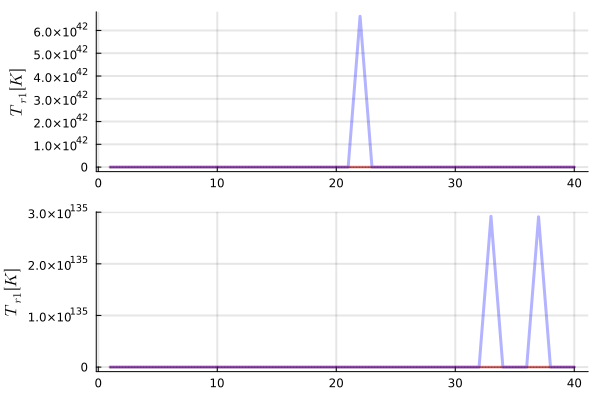

In [20]:
p1 = plot(layout = (num_subplots, 1),fmt = :svg, resolution = (600, 400), latex=true,gridlinewidth=2) 

# Loop to generate subplots 
for mm in 1:num_subplots     
    # Plot data based on the subplot index 
    # limits
    plot!(subplot=mm,ts,Tr_max*ones(length(ts)),linestyle = :dot,linecolor = :black,label="")
     
    for nn in 1:n_MC
        plot!(subplot=mm,ts,TrPlant[1,:,nn,mm],linewidth=3,linealpha = 0.3,linecolor = CList[nn],legend=false)
    end
    
    # Add labels, titles, or other customizations to each subplot 
    ylabel!(L"T_{r1} [K]") 
    
end 

# Display the subplots 
display(p1)

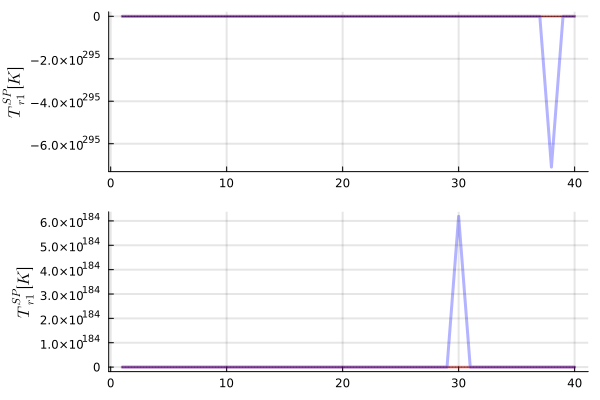

In [21]:
p2 = plot(layout = (num_subplots, 1),fmt = :svg, resolution = (600, 400), latex=true,gridlinewidth=2) 

# Loop to generate subplots 
for mm in 1:num_subplots 
    # limits
#     if mm == 1
#         plot!(subplot=ss,legend=:topleft)
#     end
    plot!(subplot=mm,ts,yspMax[1]*ones(length(ts)),linestyle = :dot,linecolor = :black,label="")
    
    for nn in 1:n_MC
        plot!(subplot=mm,ts,yspPlant[1,:,nn,mm],linewidth=3,linealpha = 0.3,linecolor = CList[nn],legend=false)
    end
     
    # Add labels, titles, or other customizations to each subplot 
    ylabel!(L"T_{r1}^{SP} [K]") 
end 

# Display the subplots 
display(p2)

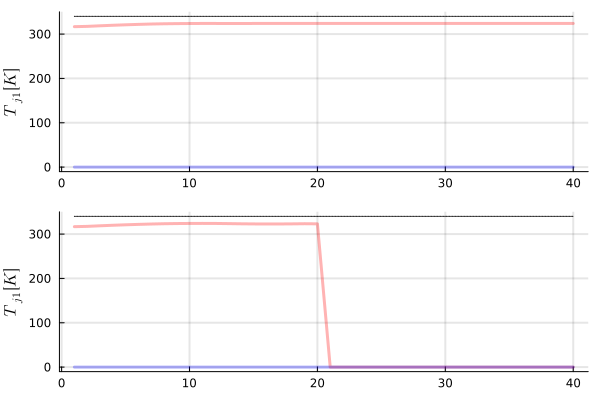

In [22]:
p3 = plot(layout = (num_subplots, 1),fmt = :svg, resolution = (600, 400), latex=true,gridlinewidth=2,legend=:topleft) 

# Loop to generate subplots 
for mm in 1:num_subplots  
    # limits
    plot!(subplot=mm,ts,Tj_max[1]*ones(length(ts)),linestyle = :dot,linecolor = :black,label="")
    
    for nn in 1:n_MC
        plot!(subplot=mm,ts,TjPlant[1,:,nn,mm],linewidth=3,linealpha = 0.3,linecolor = CList[nn],legend=false)
    end
    
    # Add labels, titles, or other customizations to each subplot 
    ylabel!(L"T_{j1} [K]") 
end 

# Display the subplots 
display(p3)

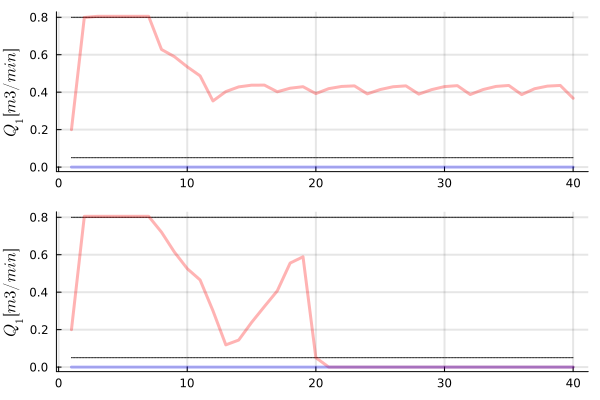

In [23]:
p4 = plot(layout = (num_subplots, 1),fmt = :svg, resolution = (600, 400), latex=true,gridlinewidth=2,legend=:bottomleft) 

# Loop to generate subplots 
for mm in 1:num_subplots  
    # limits
    plot!(subplot=mm,ts,Qf_max*ones(length(ts)),linestyle = :dot,linecolor = :black,label="")
    plot!(subplot=mm,ts,Q_min*ones(length(ts)),linestyle = :dot,linecolor = :black,label="")
    
    for nn in 1:n_MC
        plot!(subplot=mm,ts,QPlant[:,nn,mm],linewidth=3,linealpha = 0.3,linecolor = CList[nn],legend=false)
    end
    
    # Add labels, titles, or other customizations to each subplot 
    ylabel!(L"Q_{1} [m3/min]") 
end 

# Display the subplots 
display(p4)

- Reactor 2: Reactor Temperature / Setpoint / Jacket Temperature / MV

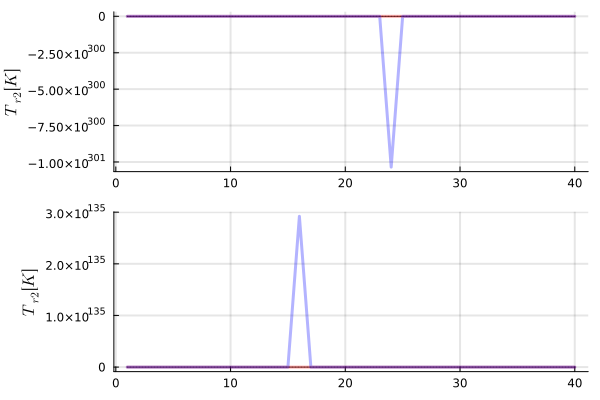

In [24]:
p5 = plot(layout = (num_subplots, 1),fmt = :svg, resolution = (600, 400), latex=true,gridlinewidth=2,legend=:topleft) 

# Loop to generate subplots 
for mm in 1:num_subplots 
    # limits
    plot!(subplot=mm,ts,Tr_max*ones(length(ts)),linestyle = :dot,linecolor = :black,label="")
    
    for nn in 1:n_MC
        plot!(subplot=mm,ts,TrPlant[2,:,nn,mm],linewidth=3,linealpha = 0.3,linecolor = CList[nn],legend=false)
    end
    
    # Add labels, titles, or other customizations to each subplot 
    ylabel!(L"T_{r2} [K]") 
end 

# Display the subplots 
display(p5)

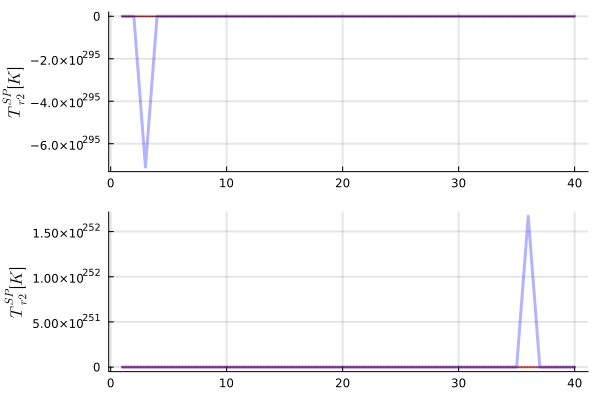

In [25]:
p6 = plot(layout = (num_subplots, 1),fmt = :svg, resolution = (600, 400), latex=true,gridlinewidth=2,legend=:topleft) 

# Loop to generate subplots 
for mm in 1:num_subplots  
    # limits
    #plot!(subplot=mm,ts,yspMin[2]*ones(length(ts)),linestyle = :dot,linecolor = :black,label="")
    plot!(subplot=mm,ts,yspMax[2]*ones(length(ts)),linestyle = :dot,linecolor = :black,label="")
    
    for nn in 1:n_MC
        plot!(subplot=mm,ts,yspPlant[2,:,nn,mm],linewidth=3,linealpha = 0.3,linecolor = CList[nn],legend=false)
    end
    
    # Add labels, titles, or other customizations to each subplot 
    ylabel!(L"T_{r2}^{SP} [K]") 
end 


# Display the subplots 
display(p6)

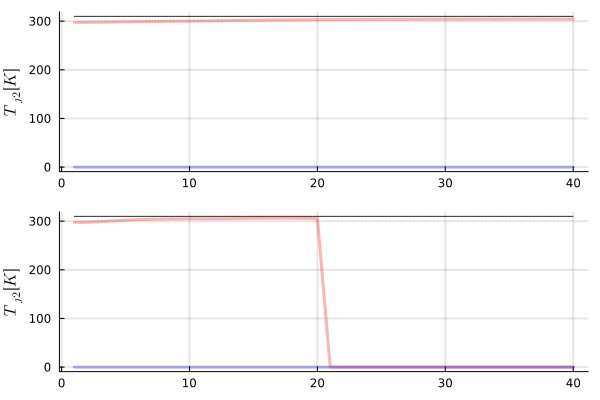

In [26]:
p7 = plot(layout = (num_subplots, 1),fmt = :svg, resolution = (600, 400), latex=true,gridlinewidth=2) 

# Loop to generate subplots 
for mm in 1:num_subplots 
    # limits
    plot!(subplot=mm,ts,Tj_max[2]*ones(length(ts)),linestyle = :dot,linecolor = :black,label="")
    
    for nn in 1:n_MC
        plot!(subplot=mm,ts,TjPlant[2,:,nn,mm],linewidth=3,linealpha = 0.3,linecolor = CList[nn],legend=false)
    end
    
    # Add labels, titles, or other customizations to each subplot 
    ylabel!(L"T_{j2} [K]") 
end 

# Display the subplots 
display(p7)

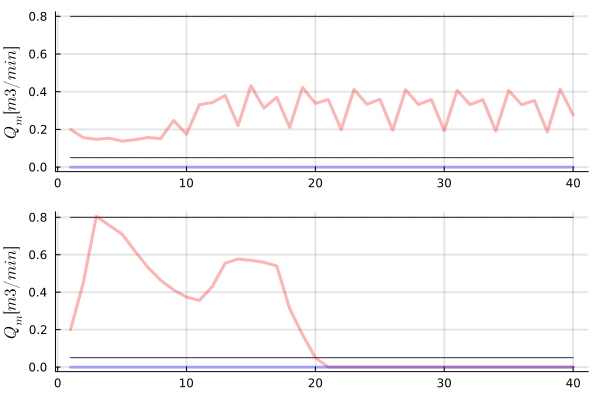

In [27]:
p8 = plot(layout = (num_subplots, 1),fmt = :svg, resolution = (600, 400), latex=true,gridlinewidth=2,legend=:topleft) 

# Loop to generate subplots 
for mm in 1:num_subplots 

    # limits
    plot!(subplot=mm,ts,Qf_max*ones(length(ts)),linestyle = :dot,linecolor = :black,label="")
    plot!(subplot=mm,ts,Qm_min*ones(length(ts)),linestyle = :dot,linecolor = :black,label="")
    
    for nn in 1:n_MC
        plot!(subplot=mm,ts,QmPlant[:,nn,mm],linewidth=3,linealpha = 0.3,linecolor = CList[nn],legend=false)
    end
    
    # Add labels, titles, or other customizations to each subplot 
    ylabel!(L"Q_{m} [m3/min]") 
end 


# Display the subplots 
display(p8)